In [114]:
# pip install imgaug

In [90]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import math
from urllib.parse import quote_plus
from imgaug.augmentables.bbs import BoundingBox
from imgaug.augmentables.polys import Polygon

In [25]:
base_dir = 'dataset'

In [26]:
ls dataset

annotations-disease.json  count-dataset.csv     dataset-meta.json      images/
annotations-healed.json   dataset-disease.json  dataset-test.json
annotations-healing.json  dataset-healed.json   dataset-train.json
annotations.json          dataset-healing.json  dataset-validate.json


In [27]:
df_datasets = {}
for dataset in ['train', 'validate', 'test']:
    df_datasets[dataset] = pd.read_json(os.path.join(base_dir, f"dataset-{dataset}.json"))
df_datasets.keys()

dict_keys(['train', 'validate', 'test'])

In [28]:
with open(os.path.join(base_dir, 'dataset-meta.json'), 'r') as f:
    meta = json.load(f)
meta

{'class': ['disease', 'healed', 'healing']}

In [143]:
def _get_bbox(points, width, height):
    points = np.array(points)/100
    X = points[:,0]
    Y = points[:,1]
    min_x, max_x = X.min()*width, X.max()*width
    min_y, max_y = Y.min()*height, Y.max()*height
    return [min_x, min_y, max_x, max_y]

def _convert_points(points, width, height):
    points = np.array(points)/100
    points[:,0] = points[:,0] * width
    points[:,1] = points[:,1] * height
    return points.tolist()

def _get_obj(annotation): 
    points = annotation.get('value', {}).get('points')
    img_w, img_h = annotation.get('original_width'), annotation.get('original_height')
    labels = annotation.get('value',{}).get('polygonlabels')
    label = labels[0] if len(labels) else "-"
    obj = {
        "bbox": _get_bbox(points, img_w, img_h),
        "bbox_mode": 0,
        "segmentation": _convert_points(points, img_w, img_h),
        "category_id": meta.get('class').index(label) if label in meta.get('class') else -1
    }
    return obj

def _get_annotations(annotations):
    segmentations = [elm.get('result', []) for elm in annotations]
    segmentations = [item for sublist in segmentations for item in sublist]
    data = [_get_obj(elm) for elm in segmentations]
    return data

def get_annotations(row):
    record = {
        'image_id': row['id'],
        'image_path': os.path.join(base_dir, 'images', quote_plus(row['file_upload'])),
        'annotations': _get_annotations(row['annotations'])
    }
    height, width = cv2.imread(record.get('image_path')).shape[:2]
    record.update({
         'file_name': record['image_path'],
         'height': height,
         'width': width
    })
    return record

In [144]:
for dataset, df in df_datasets.items():
    df['data-annatations'] = df.apply(lambda x: get_annotations(x), axis=1)

In [145]:
os.makedirs(os.path.join(base_dir, 'fRcnn'), exist_ok=True)
for dataset, df in df_datasets.items():
    with open(os.path.join(base_dir, 'fRcnn', f'{dataset}.json'), 'w') as f:
        json.dump(df['data-annatations'].to_list(), f)

In [146]:
def cv2plt(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

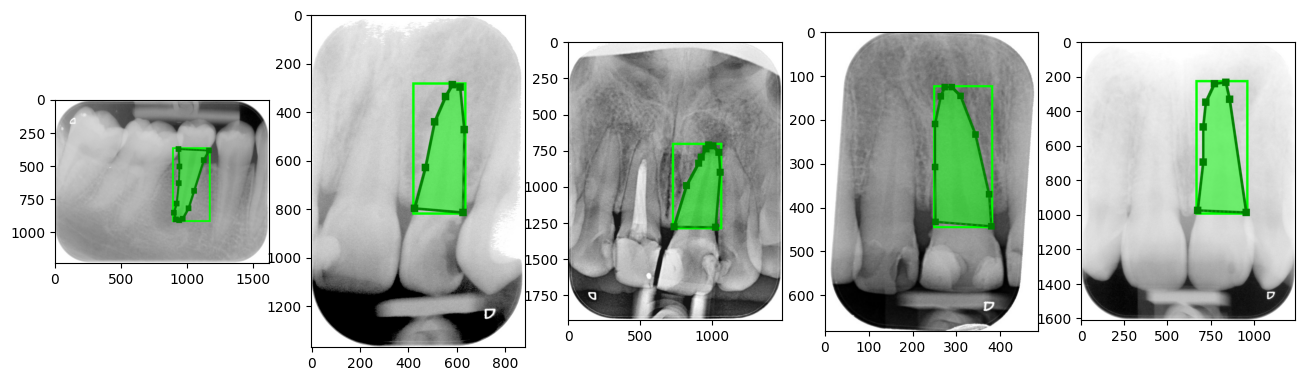

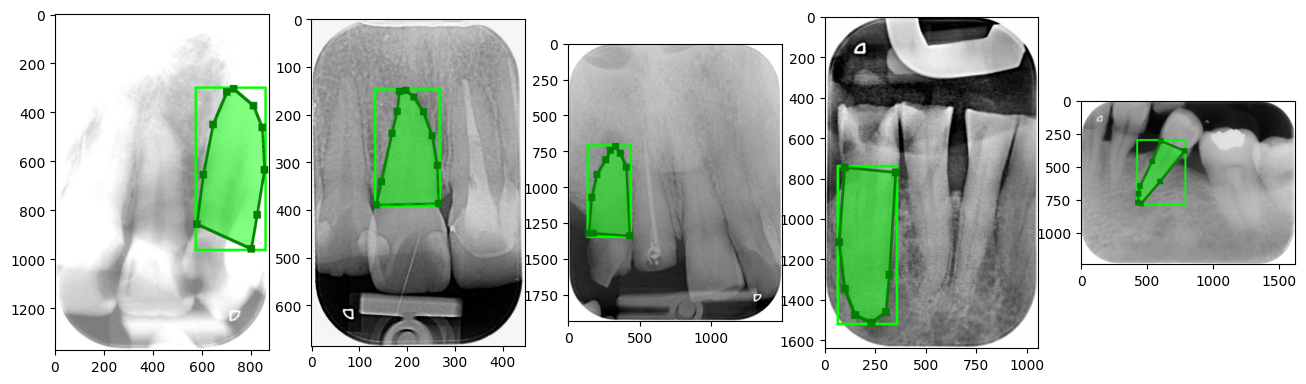

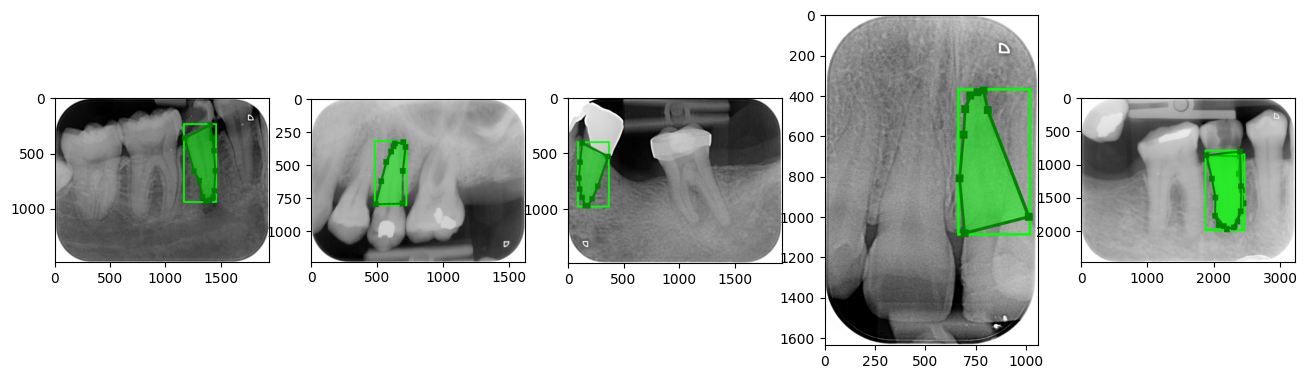

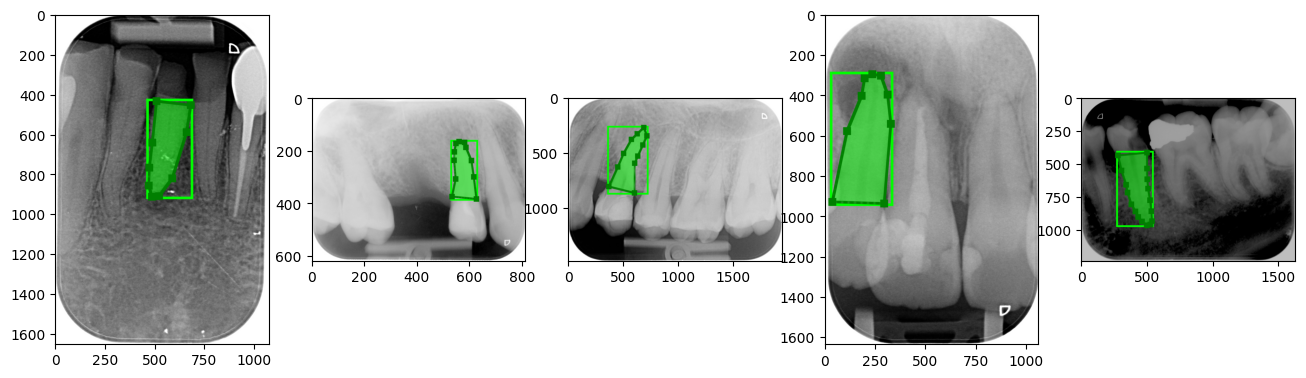

In [147]:
samples = random.sample((df_datasets['train']['data-annatations']).to_list(), k=20)

for i in range(0, len(samples)-1, 5):
    sample = samples[i:i+5]
    fig, ax = plt.subplots(1, 5, figsize=(16,10))
    for j,sample in enumerate(sample):
        frame = cv2.imread(sample['image_path'])
        h,w = frame.shape[:2]
        t = math.sqrt((w*h))/1000
        ploygon_cor = []
        for marker in sample['annotations']:
            x1,y1,x2,y2 = tuple(marker['bbox'])
            bbox = BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)
            frame = bbox.draw_on_image(frame, alpha=1, size=int(10*t))
            poly = Polygon(marker['segmentation'])
            frame = poly.draw_on_image(frame, alpha=1, size=int(10*t))
        ax[j].imshow(cv2plt(frame))
    plt.show()

In [148]:
# pip uninstall -y detectron2
# pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html
# pip install Pillow==9.0.1 setuptools==59.5.0

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.10.0+cu102 True


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt
from detectron2.structures import BoxMode

import pandas as pd
import seaborn as sns

In [3]:
base_dir = 'dataset'

In [4]:
def plot(frame):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    
def cv2plt(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [5]:
import json 

def get_dicts(d):
    with open(os.path.join(base_dir, 'fRcnn',f'{d}.json'), 'r') as f:
        data = json.load(f)
        for i, item in enumerate(data):
            for j, item2 in enumerate(item['annotations']):
                data[i]['annotations'][j]['bbox_mode'] = BoxMode.XYXY_ABS
                data[i]['annotations'][j]['segmentation'] = [[item for sublist in item2['segmentation'] for item in sublist]]
        return data

In [6]:
# get_dicts('train')[:3]

In [7]:
with open(os.path.join(base_dir, 'dataset-meta.json'), 'r') as f:
    meta = json.load(f)
meta

{'class': ['disease', 'healed', 'healing']}

In [8]:
version = "79"
try:
    MetadataCatalog.remove(f'oral_{version}_train')
    DatasetCatalog.remove(f'oral_{version}_train')
    MetadataCatalog.remove(f'oral_{version}_validate')
    DatasetCatalog.remove(f'oral_{version}_validate')
except Exception:
    pass

In [9]:
for d in ["train", "validate"]:
    DatasetCatalog.register(f"oral_{version}_{d}", lambda d=d: get_dicts(d))
    MetadataCatalog.get(f"oral_{version}_{d}").set(thing_classes=meta.get('class',[]))
oral_cancer_metadata = MetadataCatalog.get("oral_{}_train".format(version))

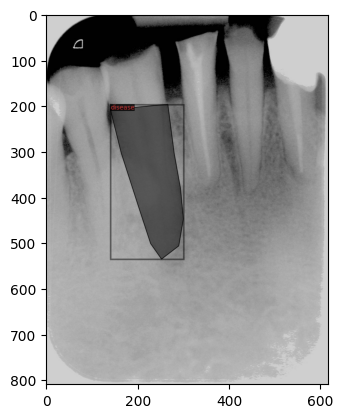

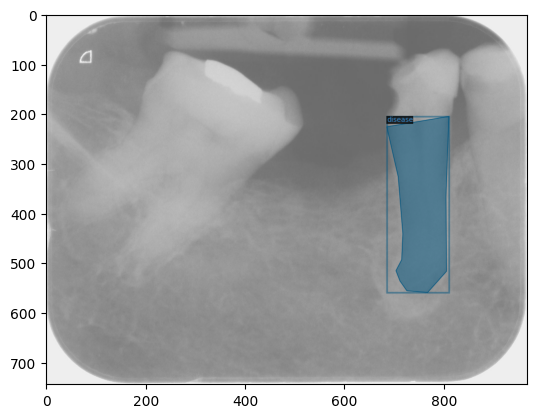

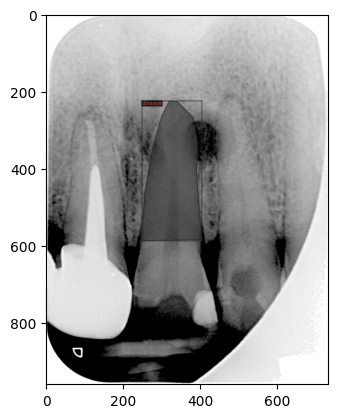

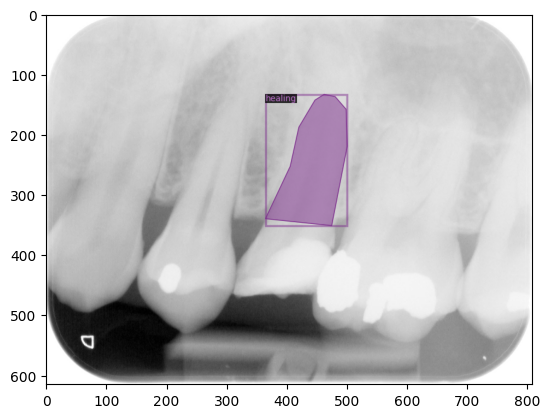

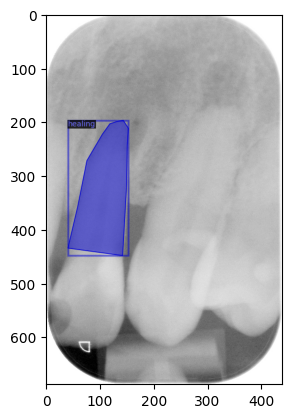

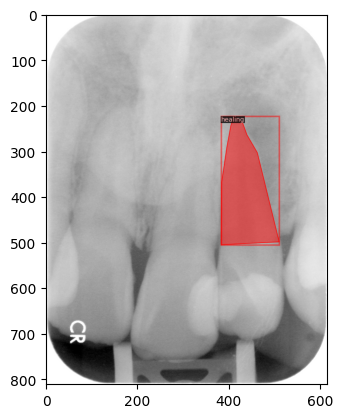

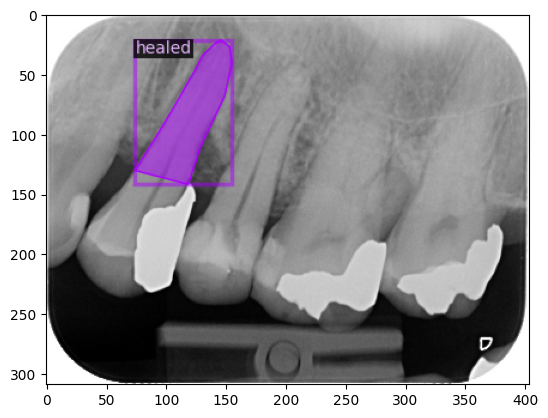

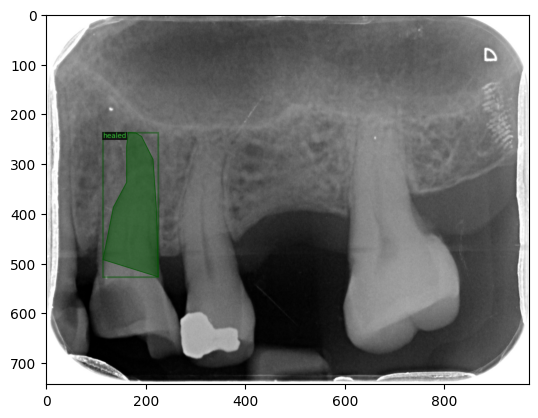

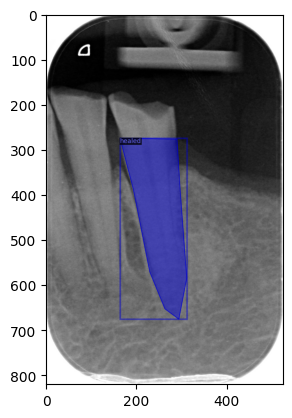

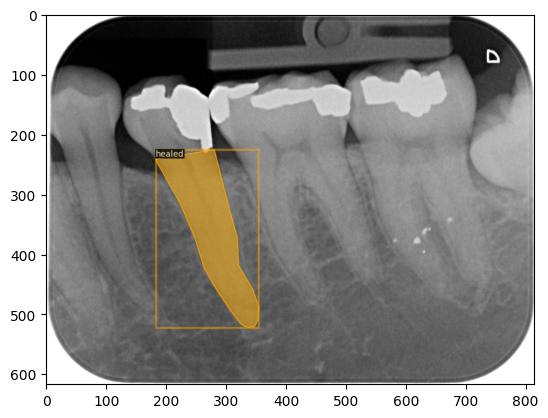

In [10]:
dataset_dicts = get_dicts("train")
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
#     print(json.dumps(d, indent=2))
    visualizer = Visualizer(img[:, :, ::-1], metadata=oral_cancer_metadata, scale=0.5)
    try:
        out = visualizer.draw_dataset_dict(d)
        plot(out.get_image()[:, :, ::-1])
    except Exception:
        plot(img)

In [11]:
output_path = os.path.join("output", "fRcnn")
os.makedirs(output_path, exist_ok=True)

In [18]:
from detectron2.engine import DefaultTrainer, launch

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("oral_{}_train".format(version),)
cfg.DATASETS.TEST = ("oral_{}_validate".format(version),)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.NUM_GPUS = 1

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(meta.get('class'))

os.makedirs(output_path, exist_ok=True)
cfg.OUTPUT_DIR = output_path

# skip blank annotation
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False

In [19]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 20000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)

trainer.train()

[07/25 11:43:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[07/25 11:43:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/25 11:43:19 d2.data.build]: Using training sampler TrainingSampler
[07/25 11:43:19 d2.data.common]: Serializing 801 elements to byte tensors and concatenating them all ...
[07/25 11:43:19 d2.data.common]: Serialized dataset takes 0.42 MiB
WARNING [07/25 11:43:19 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


model_final_9243eb.pkl: 144MB [00:05, 27.6MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (12, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due

[07/25 11:43:24 d2.engine.train_loop]: Starting training from iteration 0
[07/25 11:43:32 d2.utils.events]:  eta: 1:52:24  iter: 19  total_loss: 2.849  loss_cls: 1.454  loss_box_reg: 0.43  loss_mask: 0.693  loss_rpn_cls: 0.2867  loss_rpn_loc: 0.03372  time: 0.3488  data_time: 0.0714  lr: 4.9953e-06  max_mem: 11326M
[07/25 11:43:39 d2.utils.events]:  eta: 1:53:37  iter: 39  total_loss: 2.668  loss_cls: 1.271  loss_box_reg: 0.3764  loss_mask: 0.6926  loss_rpn_cls: 0.2543  loss_rpn_loc: 0.02317  time: 0.3510  data_time: 0.0497  lr: 9.9902e-06  max_mem: 11449M
[07/25 11:43:46 d2.utils.events]:  eta: 1:53:26  iter: 59  total_loss: 2.498  loss_cls: 0.999  loss_box_reg: 0.5195  loss_mask: 0.6913  loss_rpn_cls: 0.2488  loss_rpn_loc: 0.04259  time: 0.3498  data_time: 0.0423  lr: 1.4985e-05  max_mem: 11456M
[07/25 11:43:53 d2.utils.events]:  eta: 1:53:07  iter: 79  total_loss: 2.093  loss_cls: 0.7315  loss_box_reg: 0.4019  loss_mask: 0.689  loss_rpn_cls: 0.2392  loss_rpn_loc: 0.02794  time: 0.35

[07/25 11:47:19 d2.utils.events]:  eta: 1:50:19  iter: 659  total_loss: 1.052  loss_cls: 0.3685  loss_box_reg: 0.4611  loss_mask: 0.1951  loss_rpn_cls: 0.03086  loss_rpn_loc: 0.01513  time: 0.3536  data_time: 0.0420  lr: 0.00016484  max_mem: 11470M
[07/25 11:47:26 d2.utils.events]:  eta: 1:50:03  iter: 679  total_loss: 1.072  loss_cls: 0.3758  loss_box_reg: 0.4695  loss_mask: 0.1864  loss_rpn_cls: 0.02471  loss_rpn_loc: 0.01416  time: 0.3536  data_time: 0.0530  lr: 0.00016983  max_mem: 11470M
[07/25 11:47:33 d2.utils.events]:  eta: 1:50:11  iter: 699  total_loss: 1.088  loss_cls: 0.3412  loss_box_reg: 0.5101  loss_mask: 0.1874  loss_rpn_cls: 0.0272  loss_rpn_loc: 0.01491  time: 0.3538  data_time: 0.0516  lr: 0.00017483  max_mem: 11470M
[07/25 11:47:40 d2.utils.events]:  eta: 1:50:18  iter: 719  total_loss: 1.017  loss_cls: 0.3312  loss_box_reg: 0.4623  loss_mask: 0.1835  loss_rpn_cls: 0.02991  loss_rpn_loc: 0.01553  time: 0.3537  data_time: 0.0378  lr: 0.00017982  max_mem: 11470M
[07/2

[07/25 11:51:09 d2.utils.events]:  eta: 1:47:38  iter: 1299  total_loss: 0.8099  loss_cls: 0.2886  loss_box_reg: 0.3417  loss_mask: 0.1529  loss_rpn_cls: 0.01906  loss_rpn_loc: 0.01416  time: 0.3547  data_time: 0.0604  lr: 0.00025  max_mem: 11470M
[07/25 11:51:16 d2.utils.events]:  eta: 1:47:33  iter: 1319  total_loss: 0.7765  loss_cls: 0.2572  loss_box_reg: 0.3398  loss_mask: 0.1475  loss_rpn_cls: 0.02  loss_rpn_loc: 0.01332  time: 0.3546  data_time: 0.0367  lr: 0.00025  max_mem: 11470M
[07/25 11:51:23 d2.utils.events]:  eta: 1:47:31  iter: 1339  total_loss: 0.7741  loss_cls: 0.2598  loss_box_reg: 0.3111  loss_mask: 0.1421  loss_rpn_cls: 0.01846  loss_rpn_loc: 0.01261  time: 0.3545  data_time: 0.0453  lr: 0.00025  max_mem: 11470M
[07/25 11:51:31 d2.utils.events]:  eta: 1:47:18  iter: 1359  total_loss: 0.83  loss_cls: 0.2969  loss_box_reg: 0.3441  loss_mask: 0.1473  loss_rpn_cls: 0.01559  loss_rpn_loc: 0.01259  time: 0.3545  data_time: 0.0355  lr: 0.00025  max_mem: 11470M
[07/25 11:51:

[07/25 11:55:06 d2.utils.events]:  eta: 1:43:23  iter: 1959  total_loss: 0.7363  loss_cls: 0.2555  loss_box_reg: 0.2934  loss_mask: 0.126  loss_rpn_cls: 0.01439  loss_rpn_loc: 0.01199  time: 0.3548  data_time: 0.0328  lr: 0.00025  max_mem: 11470M
[07/25 11:55:14 d2.utils.events]:  eta: 1:43:22  iter: 1979  total_loss: 0.6627  loss_cls: 0.2383  loss_box_reg: 0.2635  loss_mask: 0.1219  loss_rpn_cls: 0.01925  loss_rpn_loc: 0.01188  time: 0.3549  data_time: 0.0591  lr: 0.00025  max_mem: 11470M
[07/25 11:55:21 d2.utils.events]:  eta: 1:43:31  iter: 1999  total_loss: 0.6652  loss_cls: 0.2384  loss_box_reg: 0.2995  loss_mask: 0.1178  loss_rpn_cls: 0.01396  loss_rpn_loc: 0.01082  time: 0.3550  data_time: 0.0574  lr: 0.00025  max_mem: 11470M
[07/25 11:55:28 d2.utils.events]:  eta: 1:43:38  iter: 2019  total_loss: 0.6583  loss_cls: 0.2329  loss_box_reg: 0.282  loss_mask: 0.1251  loss_rpn_cls: 0.01373  loss_rpn_loc: 0.01473  time: 0.3551  data_time: 0.0522  lr: 0.00025  max_mem: 11470M
[07/25 11:

[07/25 11:58:59 d2.utils.events]:  eta: 1:40:20  iter: 2599  total_loss: 0.6075  loss_cls: 0.2013  loss_box_reg: 0.2441  loss_mask: 0.1151  loss_rpn_cls: 0.01551  loss_rpn_loc: 0.01079  time: 0.3562  data_time: 0.0600  lr: 0.00025  max_mem: 11470M
[07/25 11:59:07 d2.utils.events]:  eta: 1:40:11  iter: 2619  total_loss: 0.6069  loss_cls: 0.2112  loss_box_reg: 0.2476  loss_mask: 0.1293  loss_rpn_cls: 0.01729  loss_rpn_loc: 0.0114  time: 0.3561  data_time: 0.0433  lr: 0.00025  max_mem: 11470M
[07/25 11:59:14 d2.utils.events]:  eta: 1:40:00  iter: 2639  total_loss: 0.575  loss_cls: 0.1511  loss_box_reg: 0.255  loss_mask: 0.1127  loss_rpn_cls: 0.01491  loss_rpn_loc: 0.01225  time: 0.3561  data_time: 0.0444  lr: 0.00025  max_mem: 11470M
[07/25 11:59:21 d2.utils.events]:  eta: 1:39:55  iter: 2659  total_loss: 0.5962  loss_cls: 0.1789  loss_box_reg: 0.2633  loss_mask: 0.1207  loss_rpn_cls: 0.01395  loss_rpn_loc: 0.0119  time: 0.3561  data_time: 0.0437  lr: 0.00025  max_mem: 11470M
[07/25 11:59

[07/25 12:02:51 d2.utils.events]:  eta: 1:36:48  iter: 3239  total_loss: 0.5364  loss_cls: 0.1322  loss_box_reg: 0.2224  loss_mask: 0.1189  loss_rpn_cls: 0.0147  loss_rpn_loc: 0.01029  time: 0.3565  data_time: 0.0604  lr: 0.00025  max_mem: 11470M
[07/25 12:02:58 d2.utils.events]:  eta: 1:36:40  iter: 3259  total_loss: 0.5538  loss_cls: 0.1523  loss_box_reg: 0.2283  loss_mask: 0.1153  loss_rpn_cls: 0.01371  loss_rpn_loc: 0.01234  time: 0.3566  data_time: 0.0537  lr: 0.00025  max_mem: 11470M
[07/25 12:03:05 d2.utils.events]:  eta: 1:36:28  iter: 3279  total_loss: 0.5644  loss_cls: 0.163  loss_box_reg: 0.2394  loss_mask: 0.1125  loss_rpn_cls: 0.01715  loss_rpn_loc: 0.01143  time: 0.3565  data_time: 0.0408  lr: 0.00025  max_mem: 11470M
[07/25 12:03:12 d2.utils.events]:  eta: 1:36:21  iter: 3299  total_loss: 0.5681  loss_cls: 0.1467  loss_box_reg: 0.264  loss_mask: 0.1181  loss_rpn_cls: 0.0159  loss_rpn_loc: 0.01092  time: 0.3564  data_time: 0.0399  lr: 0.00025  max_mem: 11470M
[07/25 12:03

[07/25 12:06:42 d2.utils.events]:  eta: 1:33:07  iter: 3879  total_loss: 0.5249  loss_cls: 0.1375  loss_box_reg: 0.245  loss_mask: 0.122  loss_rpn_cls: 0.01219  loss_rpn_loc: 0.01089  time: 0.3566  data_time: 0.0296  lr: 0.00025  max_mem: 11470M
[07/25 12:06:49 d2.utils.events]:  eta: 1:33:03  iter: 3899  total_loss: 0.5433  loss_cls: 0.1391  loss_box_reg: 0.2329  loss_mask: 0.119  loss_rpn_cls: 0.01458  loss_rpn_loc: 0.01041  time: 0.3566  data_time: 0.0441  lr: 0.00025  max_mem: 11470M
[07/25 12:06:56 d2.utils.events]:  eta: 1:32:56  iter: 3919  total_loss: 0.4837  loss_cls: 0.1336  loss_box_reg: 0.2288  loss_mask: 0.1134  loss_rpn_cls: 0.01276  loss_rpn_loc: 0.01095  time: 0.3566  data_time: 0.0578  lr: 0.00025  max_mem: 11470M
[07/25 12:07:03 d2.utils.events]:  eta: 1:32:51  iter: 3939  total_loss: 0.5335  loss_cls: 0.1329  loss_box_reg: 0.2453  loss_mask: 0.1167  loss_rpn_cls: 0.01296  loss_rpn_loc: 0.01259  time: 0.3566  data_time: 0.0448  lr: 0.00025  max_mem: 11470M
[07/25 12:0

[07/25 12:10:34 d2.utils.events]:  eta: 1:28:54  iter: 4519  total_loss: 0.4496  loss_cls: 0.08787  loss_box_reg: 0.2314  loss_mask: 0.1131  loss_rpn_cls: 0.01196  loss_rpn_loc: 0.009444  time: 0.3571  data_time: 0.0408  lr: 0.00025  max_mem: 11470M
[07/25 12:10:41 d2.utils.events]:  eta: 1:28:46  iter: 4539  total_loss: 0.5021  loss_cls: 0.1228  loss_box_reg: 0.2463  loss_mask: 0.1101  loss_rpn_cls: 0.01183  loss_rpn_loc: 0.01142  time: 0.3570  data_time: 0.0407  lr: 0.00025  max_mem: 11470M
[07/25 12:10:48 d2.utils.events]:  eta: 1:28:40  iter: 4559  total_loss: 0.5027  loss_cls: 0.122  loss_box_reg: 0.2347  loss_mask: 0.111  loss_rpn_cls: 0.01455  loss_rpn_loc: 0.01094  time: 0.3570  data_time: 0.0449  lr: 0.00025  max_mem: 11470M
[07/25 12:10:55 d2.utils.events]:  eta: 1:28:33  iter: 4579  total_loss: 0.5214  loss_cls: 0.1227  loss_box_reg: 0.2128  loss_mask: 0.1055  loss_rpn_cls: 0.01178  loss_rpn_loc: 0.01004  time: 0.3570  data_time: 0.0642  lr: 0.00025  max_mem: 11470M
[07/25 1

[07/25 12:14:24 d2.utils.events]:  eta: 1:25:32  iter: 5159  total_loss: 0.4997  loss_cls: 0.1146  loss_box_reg: 0.2246  loss_mask: 0.1091  loss_rpn_cls: 0.01285  loss_rpn_loc: 0.01221  time: 0.3570  data_time: 0.0446  lr: 0.00025  max_mem: 11470M
[07/25 12:14:32 d2.utils.events]:  eta: 1:25:25  iter: 5179  total_loss: 0.5019  loss_cls: 0.1161  loss_box_reg: 0.2429  loss_mask: 0.1088  loss_rpn_cls: 0.01623  loss_rpn_loc: 0.0107  time: 0.3570  data_time: 0.0551  lr: 0.00025  max_mem: 11470M
[07/25 12:14:39 d2.utils.events]:  eta: 1:25:22  iter: 5199  total_loss: 0.4783  loss_cls: 0.1327  loss_box_reg: 0.2164  loss_mask: 0.1115  loss_rpn_cls: 0.01141  loss_rpn_loc: 0.009706  time: 0.3571  data_time: 0.0618  lr: 0.00025  max_mem: 11470M
[07/25 12:14:46 d2.utils.events]:  eta: 1:25:11  iter: 5219  total_loss: 0.4649  loss_cls: 0.1043  loss_box_reg: 0.2162  loss_mask: 0.1115  loss_rpn_cls: 0.0107  loss_rpn_loc: 0.008983  time: 0.3571  data_time: 0.0537  lr: 0.00025  max_mem: 11470M
[07/25 1

[07/25 12:20:19 d2.utils.events]:  eta: 1:20:34  iter: 6139  total_loss: 0.4279  loss_cls: 0.07289  loss_box_reg: 0.2043  loss_mask: 0.1112  loss_rpn_cls: 0.01384  loss_rpn_loc: 0.01222  time: 0.3572  data_time: 0.0455  lr: 0.00025  max_mem: 11470M
[07/25 12:20:26 d2.utils.events]:  eta: 1:20:29  iter: 6159  total_loss: 0.4123  loss_cls: 0.09561  loss_box_reg: 0.2082  loss_mask: 0.1034  loss_rpn_cls: 0.01607  loss_rpn_loc: 0.009949  time: 0.3571  data_time: 0.0451  lr: 0.00025  max_mem: 11470M
[07/25 12:20:33 d2.utils.events]:  eta: 1:20:20  iter: 6179  total_loss: 0.4172  loss_cls: 0.08556  loss_box_reg: 0.1974  loss_mask: 0.1095  loss_rpn_cls: 0.009985  loss_rpn_loc: 0.01138  time: 0.3571  data_time: 0.0422  lr: 0.00025  max_mem: 11470M
[07/25 12:20:40 d2.utils.events]:  eta: 1:20:13  iter: 6199  total_loss: 0.4267  loss_cls: 0.08238  loss_box_reg: 0.2174  loss_mask: 0.1079  loss_rpn_cls: 0.01011  loss_rpn_loc: 0.01161  time: 0.3572  data_time: 0.0560  lr: 0.00025  max_mem: 11470M
[0

[07/25 12:24:12 d2.utils.events]:  eta: 1:16:46  iter: 6779  total_loss: 0.4437  loss_cls: 0.07547  loss_box_reg: 0.216  loss_mask: 0.1081  loss_rpn_cls: 0.009339  loss_rpn_loc: 0.0112  time: 0.3574  data_time: 0.0539  lr: 0.00025  max_mem: 11470M
[07/25 12:24:19 d2.utils.events]:  eta: 1:16:34  iter: 6799  total_loss: 0.4592  loss_cls: 0.09301  loss_box_reg: 0.204  loss_mask: 0.1129  loss_rpn_cls: 0.01197  loss_rpn_loc: 0.01219  time: 0.3574  data_time: 0.0487  lr: 0.00025  max_mem: 11470M
[07/25 12:24:27 d2.utils.events]:  eta: 1:16:32  iter: 6819  total_loss: 0.4065  loss_cls: 0.06493  loss_box_reg: 0.2021  loss_mask: 0.103  loss_rpn_cls: 0.01122  loss_rpn_loc: 0.008598  time: 0.3575  data_time: 0.0911  lr: 0.00025  max_mem: 11470M
[07/25 12:24:34 d2.utils.events]:  eta: 1:16:20  iter: 6839  total_loss: 0.3874  loss_cls: 0.06102  loss_box_reg: 0.2059  loss_mask: 0.1021  loss_rpn_cls: 0.0105  loss_rpn_loc: 0.008692  time: 0.3575  data_time: 0.0611  lr: 0.00025  max_mem: 11470M
[07/25

[07/25 12:28:04 d2.utils.events]:  eta: 1:12:53  iter: 7419  total_loss: 0.4308  loss_cls: 0.08237  loss_box_reg: 0.2202  loss_mask: 0.1088  loss_rpn_cls: 0.01096  loss_rpn_loc: 0.0111  time: 0.3576  data_time: 0.0592  lr: 0.00025  max_mem: 11470M
[07/25 12:28:12 d2.utils.events]:  eta: 1:12:46  iter: 7439  total_loss: 0.4106  loss_cls: 0.06085  loss_box_reg: 0.1987  loss_mask: 0.09839  loss_rpn_cls: 0.01178  loss_rpn_loc: 0.01047  time: 0.3576  data_time: 0.0603  lr: 0.00025  max_mem: 11470M
[07/25 12:28:19 d2.utils.events]:  eta: 1:12:40  iter: 7459  total_loss: 0.4086  loss_cls: 0.05939  loss_box_reg: 0.2033  loss_mask: 0.1029  loss_rpn_cls: 0.01203  loss_rpn_loc: 0.009727  time: 0.3576  data_time: 0.0506  lr: 0.00025  max_mem: 11470M
[07/25 12:28:26 d2.utils.events]:  eta: 1:12:38  iter: 7479  total_loss: 0.3746  loss_cls: 0.05865  loss_box_reg: 0.1888  loss_mask: 0.1047  loss_rpn_cls: 0.01127  loss_rpn_loc: 0.01083  time: 0.3576  data_time: 0.0422  lr: 0.00025  max_mem: 11470M
[07

[07/25 12:31:56 d2.utils.events]:  eta: 1:09:18  iter: 8059  total_loss: 0.3642  loss_cls: 0.05892  loss_box_reg: 0.1852  loss_mask: 0.1016  loss_rpn_cls: 0.009235  loss_rpn_loc: 0.0101  time: 0.3577  data_time: 0.0583  lr: 0.00025  max_mem: 11470M
[07/25 12:32:03 d2.utils.events]:  eta: 1:09:11  iter: 8079  total_loss: 0.4251  loss_cls: 0.0763  loss_box_reg: 0.2104  loss_mask: 0.1014  loss_rpn_cls: 0.009047  loss_rpn_loc: 0.01079  time: 0.3576  data_time: 0.0361  lr: 0.00025  max_mem: 11470M
[07/25 12:32:10 d2.utils.events]:  eta: 1:09:06  iter: 8099  total_loss: 0.4003  loss_cls: 0.0678  loss_box_reg: 0.2007  loss_mask: 0.1046  loss_rpn_cls: 0.01299  loss_rpn_loc: 0.008685  time: 0.3576  data_time: 0.0401  lr: 0.00025  max_mem: 11470M
[07/25 12:32:17 d2.utils.events]:  eta: 1:08:58  iter: 8119  total_loss: 0.3694  loss_cls: 0.05174  loss_box_reg: 0.1849  loss_mask: 0.1037  loss_rpn_cls: 0.01035  loss_rpn_loc: 0.01187  time: 0.3576  data_time: 0.0566  lr: 0.00025  max_mem: 11470M
[07/

[07/25 12:35:50 d2.utils.events]:  eta: 1:05:19  iter: 8699  total_loss: 0.4257  loss_cls: 0.07275  loss_box_reg: 0.192  loss_mask: 0.1077  loss_rpn_cls: 0.01198  loss_rpn_loc: 0.01119  time: 0.3580  data_time: 0.0560  lr: 0.00025  max_mem: 11470M
[07/25 12:35:57 d2.utils.events]:  eta: 1:05:15  iter: 8719  total_loss: 0.3646  loss_cls: 0.06169  loss_box_reg: 0.1817  loss_mask: 0.09908  loss_rpn_cls: 0.01117  loss_rpn_loc: 0.007663  time: 0.3580  data_time: 0.0681  lr: 0.00025  max_mem: 11470M
[07/25 12:36:04 d2.utils.events]:  eta: 1:05:08  iter: 8739  total_loss: 0.3934  loss_cls: 0.05793  loss_box_reg: 0.1888  loss_mask: 0.1007  loss_rpn_cls: 0.01031  loss_rpn_loc: 0.01093  time: 0.3580  data_time: 0.0501  lr: 0.00025  max_mem: 11470M
[07/25 12:36:11 d2.utils.events]:  eta: 1:05:04  iter: 8759  total_loss: 0.374  loss_cls: 0.06065  loss_box_reg: 0.1872  loss_mask: 0.1057  loss_rpn_cls: 0.01087  loss_rpn_loc: 0.009245  time: 0.3580  data_time: 0.0513  lr: 0.00025  max_mem: 11470M
[07

[07/25 12:39:43 d2.utils.events]:  eta: 1:01:45  iter: 9339  total_loss: 0.416  loss_cls: 0.05737  loss_box_reg: 0.1929  loss_mask: 0.1024  loss_rpn_cls: 0.009059  loss_rpn_loc: 0.01143  time: 0.3581  data_time: 0.0666  lr: 0.00025  max_mem: 11470M
[07/25 12:39:50 d2.utils.events]:  eta: 1:01:36  iter: 9359  total_loss: 0.3668  loss_cls: 0.06455  loss_box_reg: 0.2061  loss_mask: 0.09646  loss_rpn_cls: 0.008282  loss_rpn_loc: 0.009266  time: 0.3581  data_time: 0.0514  lr: 0.00025  max_mem: 11470M
[07/25 12:39:57 d2.utils.events]:  eta: 1:01:28  iter: 9379  total_loss: 0.3765  loss_cls: 0.05618  loss_box_reg: 0.1954  loss_mask: 0.1036  loss_rpn_cls: 0.009822  loss_rpn_loc: 0.0124  time: 0.3581  data_time: 0.0418  lr: 0.00025  max_mem: 11470M
[07/25 12:40:04 d2.utils.events]:  eta: 1:01:24  iter: 9399  total_loss: 0.3947  loss_cls: 0.0574  loss_box_reg: 0.1856  loss_mask: 0.1022  loss_rpn_cls: 0.01141  loss_rpn_loc: 0.01008  time: 0.3581  data_time: 0.0541  lr: 0.00025  max_mem: 11470M
[0

[07/25 12:43:40 d2.utils.events]:  eta: 0:57:41  iter: 9999  total_loss: 0.3823  loss_cls: 0.06271  loss_box_reg: 0.1912  loss_mask: 0.1013  loss_rpn_cls: 0.01004  loss_rpn_loc: 0.01114  time: 0.3581  data_time: 0.0462  lr: 0.00025  max_mem: 11470M
[07/25 12:43:49 d2.utils.events]:  eta: 0:57:35  iter: 10019  total_loss: 0.3827  loss_cls: 0.07141  loss_box_reg: 0.1834  loss_mask: 0.1027  loss_rpn_cls: 0.009927  loss_rpn_loc: 0.009945  time: 0.3581  data_time: 0.0613  lr: 0.00025  max_mem: 11470M
[07/25 12:43:56 d2.utils.events]:  eta: 0:57:24  iter: 10039  total_loss: 0.3676  loss_cls: 0.05274  loss_box_reg: 0.1881  loss_mask: 0.09867  loss_rpn_cls: 0.01004  loss_rpn_loc: 0.01185  time: 0.3581  data_time: 0.0492  lr: 0.00025  max_mem: 11470M
[07/25 12:44:03 d2.utils.events]:  eta: 0:57:17  iter: 10059  total_loss: 0.3941  loss_cls: 0.06543  loss_box_reg: 0.1942  loss_mask: 0.1033  loss_rpn_cls: 0.008359  loss_rpn_loc: 0.01019  time: 0.3580  data_time: 0.0408  lr: 0.00025  max_mem: 1147

[07/25 12:49:14 d2.utils.events]:  eta: 0:52:26  iter: 10919  total_loss: 0.3415  loss_cls: 0.04324  loss_box_reg: 0.1657  loss_mask: 0.09425  loss_rpn_cls: 0.01075  loss_rpn_loc: 0.008686  time: 0.3581  data_time: 0.0614  lr: 0.00025  max_mem: 11470M
[07/25 12:49:21 d2.utils.events]:  eta: 0:52:20  iter: 10939  total_loss: 0.3447  loss_cls: 0.05375  loss_box_reg: 0.1733  loss_mask: 0.0944  loss_rpn_cls: 0.008425  loss_rpn_loc: 0.008872  time: 0.3581  data_time: 0.0508  lr: 0.00025  max_mem: 11470M
[07/25 12:49:28 d2.utils.events]:  eta: 0:52:16  iter: 10959  total_loss: 0.3438  loss_cls: 0.04906  loss_box_reg: 0.1801  loss_mask: 0.09706  loss_rpn_cls: 0.01208  loss_rpn_loc: 0.01245  time: 0.3581  data_time: 0.0541  lr: 0.00025  max_mem: 11470M
[07/25 12:49:35 d2.utils.events]:  eta: 0:52:07  iter: 10979  total_loss: 0.337  loss_cls: 0.05583  loss_box_reg: 0.165  loss_mask: 0.1001  loss_rpn_cls: 0.008562  loss_rpn_loc: 0.009312  time: 0.3581  data_time: 0.0478  lr: 0.00025  max_mem: 11

[07/25 12:53:06 d2.utils.events]:  eta: 0:49:06  iter: 11559  total_loss: 0.3618  loss_cls: 0.07212  loss_box_reg: 0.1546  loss_mask: 0.09398  loss_rpn_cls: 0.009179  loss_rpn_loc: 0.01111  time: 0.3582  data_time: 0.0435  lr: 0.00025  max_mem: 11470M
[07/25 12:53:13 d2.utils.events]:  eta: 0:48:57  iter: 11579  total_loss: 0.3594  loss_cls: 0.0537  loss_box_reg: 0.1866  loss_mask: 0.09946  loss_rpn_cls: 0.009621  loss_rpn_loc: 0.009646  time: 0.3582  data_time: 0.0479  lr: 0.00025  max_mem: 11470M
[07/25 12:53:20 d2.utils.events]:  eta: 0:48:49  iter: 11599  total_loss: 0.3823  loss_cls: 0.05057  loss_box_reg: 0.1962  loss_mask: 0.1096  loss_rpn_cls: 0.009299  loss_rpn_loc: 0.01083  time: 0.3582  data_time: 0.0401  lr: 0.00025  max_mem: 11470M
[07/25 12:53:27 d2.utils.events]:  eta: 0:48:42  iter: 11619  total_loss: 0.3595  loss_cls: 0.04895  loss_box_reg: 0.1853  loss_mask: 0.09384  loss_rpn_cls: 0.01004  loss_rpn_loc: 0.01116  time: 0.3582  data_time: 0.0443  lr: 0.00025  max_mem: 1

[07/25 12:56:56 d2.utils.events]:  eta: 0:44:58  iter: 12199  total_loss: 0.364  loss_cls: 0.04725  loss_box_reg: 0.189  loss_mask: 0.09981  loss_rpn_cls: 0.009492  loss_rpn_loc: 0.01048  time: 0.3581  data_time: 0.0370  lr: 0.00025  max_mem: 11470M
[07/25 12:57:03 d2.utils.events]:  eta: 0:44:47  iter: 12219  total_loss: 0.3342  loss_cls: 0.04159  loss_box_reg: 0.1726  loss_mask: 0.0937  loss_rpn_cls: 0.01186  loss_rpn_loc: 0.009976  time: 0.3581  data_time: 0.0488  lr: 0.00025  max_mem: 11470M
[07/25 12:57:10 d2.utils.events]:  eta: 0:44:39  iter: 12239  total_loss: 0.3301  loss_cls: 0.04784  loss_box_reg: 0.1716  loss_mask: 0.09111  loss_rpn_cls: 0.007303  loss_rpn_loc: 0.01035  time: 0.3581  data_time: 0.0535  lr: 0.00025  max_mem: 11470M
[07/25 12:57:18 d2.utils.events]:  eta: 0:44:32  iter: 12259  total_loss: 0.3416  loss_cls: 0.05273  loss_box_reg: 0.1751  loss_mask: 0.09491  loss_rpn_cls: 0.008398  loss_rpn_loc: 0.009737  time: 0.3581  data_time: 0.0563  lr: 0.00025  max_mem: 1

[07/25 13:00:48 d2.utils.events]:  eta: 0:41:11  iter: 12839  total_loss: 0.3192  loss_cls: 0.04144  loss_box_reg: 0.1673  loss_mask: 0.08769  loss_rpn_cls: 0.007801  loss_rpn_loc: 0.009195  time: 0.3582  data_time: 0.0613  lr: 0.00025  max_mem: 11470M
[07/25 13:00:55 d2.utils.events]:  eta: 0:41:06  iter: 12859  total_loss: 0.3327  loss_cls: 0.04347  loss_box_reg: 0.1692  loss_mask: 0.09446  loss_rpn_cls: 0.009356  loss_rpn_loc: 0.009032  time: 0.3582  data_time: 0.0536  lr: 0.00025  max_mem: 11470M
[07/25 13:01:02 d2.utils.events]:  eta: 0:41:00  iter: 12879  total_loss: 0.3486  loss_cls: 0.04496  loss_box_reg: 0.1808  loss_mask: 0.09929  loss_rpn_cls: 0.009746  loss_rpn_loc: 0.009953  time: 0.3582  data_time: 0.0366  lr: 0.00025  max_mem: 11470M
[07/25 13:01:09 d2.utils.events]:  eta: 0:40:53  iter: 12899  total_loss: 0.3512  loss_cls: 0.04875  loss_box_reg: 0.1649  loss_mask: 0.09893  loss_rpn_cls: 0.0108  loss_rpn_loc: 0.008775  time: 0.3582  data_time: 0.0540  lr: 0.00025  max_me

[07/25 13:04:39 d2.utils.events]:  eta: 0:37:34  iter: 13479  total_loss: 0.3315  loss_cls: 0.04934  loss_box_reg: 0.167  loss_mask: 0.09978  loss_rpn_cls: 0.009026  loss_rpn_loc: 0.0095  time: 0.3582  data_time: 0.0633  lr: 0.00025  max_mem: 11470M
[07/25 13:04:46 d2.utils.events]:  eta: 0:37:28  iter: 13499  total_loss: 0.314  loss_cls: 0.04481  loss_box_reg: 0.1589  loss_mask: 0.0928  loss_rpn_cls: 0.008137  loss_rpn_loc: 0.009134  time: 0.3582  data_time: 0.0622  lr: 0.00025  max_mem: 11470M
[07/25 13:04:53 d2.utils.events]:  eta: 0:37:22  iter: 13519  total_loss: 0.3271  loss_cls: 0.03199  loss_box_reg: 0.1641  loss_mask: 0.09211  loss_rpn_cls: 0.008516  loss_rpn_loc: 0.009138  time: 0.3582  data_time: 0.0456  lr: 0.00025  max_mem: 11470M
[07/25 13:05:01 d2.utils.events]:  eta: 0:37:15  iter: 13539  total_loss: 0.3423  loss_cls: 0.03332  loss_box_reg: 0.1765  loss_mask: 0.08679  loss_rpn_cls: 0.009952  loss_rpn_loc: 0.008969  time: 0.3582  data_time: 0.0524  lr: 0.00025  max_mem: 

[07/25 13:10:25 d2.utils.events]:  eta: 0:32:10  iter: 14439  total_loss: 0.3194  loss_cls: 0.04528  loss_box_reg: 0.1569  loss_mask: 0.09645  loss_rpn_cls: 0.006997  loss_rpn_loc: 0.008245  time: 0.3582  data_time: 0.0474  lr: 0.00025  max_mem: 11470M
[07/25 13:10:32 d2.utils.events]:  eta: 0:32:03  iter: 14459  total_loss: 0.3134  loss_cls: 0.04116  loss_box_reg: 0.1644  loss_mask: 0.08992  loss_rpn_cls: 0.0051  loss_rpn_loc: 0.008969  time: 0.3582  data_time: 0.0461  lr: 0.00025  max_mem: 11470M
[07/25 13:10:39 d2.utils.events]:  eta: 0:31:53  iter: 14479  total_loss: 0.2954  loss_cls: 0.02989  loss_box_reg: 0.1569  loss_mask: 0.08832  loss_rpn_cls: 0.008151  loss_rpn_loc: 0.007883  time: 0.3581  data_time: 0.0449  lr: 0.00025  max_mem: 11470M
[07/25 13:10:47 d2.utils.events]:  eta: 0:31:45  iter: 14499  total_loss: 0.3121  loss_cls: 0.04521  loss_box_reg: 0.1693  loss_mask: 0.08645  loss_rpn_cls: 0.009058  loss_rpn_loc: 0.01021  time: 0.3582  data_time: 0.0582  lr: 0.00025  max_mem

[07/25 13:16:27 d2.utils.events]:  eta: 0:26:16  iter: 15439  total_loss: 0.2965  loss_cls: 0.03497  loss_box_reg: 0.1579  loss_mask: 0.09004  loss_rpn_cls: 0.008708  loss_rpn_loc: 0.008797  time: 0.3582  data_time: 0.0599  lr: 0.00025  max_mem: 11470M
[07/25 13:16:35 d2.utils.events]:  eta: 0:26:08  iter: 15459  total_loss: 0.3064  loss_cls: 0.03849  loss_box_reg: 0.1523  loss_mask: 0.08821  loss_rpn_cls: 0.006488  loss_rpn_loc: 0.009824  time: 0.3582  data_time: 0.0597  lr: 0.00025  max_mem: 11470M
[07/25 13:16:42 d2.utils.events]:  eta: 0:26:02  iter: 15479  total_loss: 0.3244  loss_cls: 0.04265  loss_box_reg: 0.1561  loss_mask: 0.08999  loss_rpn_cls: 0.007817  loss_rpn_loc: 0.009362  time: 0.3582  data_time: 0.0377  lr: 0.00025  max_mem: 11470M
[07/25 13:16:50 d2.utils.events]:  eta: 0:25:55  iter: 15499  total_loss: 0.3183  loss_cls: 0.04038  loss_box_reg: 0.1627  loss_mask: 0.08782  loss_rpn_cls: 0.01208  loss_rpn_loc: 0.008769  time: 0.3582  data_time: 0.0605  lr: 0.00025  max_m

[07/25 13:20:19 d2.utils.events]:  eta: 0:22:38  iter: 16079  total_loss: 0.2852  loss_cls: 0.03206  loss_box_reg: 0.149  loss_mask: 0.08497  loss_rpn_cls: 0.00609  loss_rpn_loc: 0.008208  time: 0.3583  data_time: 0.0434  lr: 0.00025  max_mem: 11470M
[07/25 13:20:26 d2.utils.events]:  eta: 0:22:31  iter: 16099  total_loss: 0.3099  loss_cls: 0.03242  loss_box_reg: 0.1561  loss_mask: 0.09152  loss_rpn_cls: 0.006748  loss_rpn_loc: 0.009894  time: 0.3582  data_time: 0.0300  lr: 0.00025  max_mem: 11470M
[07/25 13:20:33 d2.utils.events]:  eta: 0:22:24  iter: 16119  total_loss: 0.3172  loss_cls: 0.03452  loss_box_reg: 0.1679  loss_mask: 0.08862  loss_rpn_cls: 0.01014  loss_rpn_loc: 0.009696  time: 0.3582  data_time: 0.0631  lr: 0.00025  max_mem: 11470M
[07/25 13:20:41 d2.utils.events]:  eta: 0:22:17  iter: 16139  total_loss: 0.3214  loss_cls: 0.04493  loss_box_reg: 0.166  loss_mask: 0.09529  loss_rpn_cls: 0.008204  loss_rpn_loc: 0.009826  time: 0.3583  data_time: 0.0616  lr: 0.00025  max_mem:

[07/25 13:24:12 d2.utils.events]:  eta: 0:18:57  iter: 16719  total_loss: 0.3476  loss_cls: 0.04781  loss_box_reg: 0.1593  loss_mask: 0.09425  loss_rpn_cls: 0.008413  loss_rpn_loc: 0.01031  time: 0.3582  data_time: 0.0598  lr: 0.00025  max_mem: 11470M
[07/25 13:24:19 d2.utils.events]:  eta: 0:18:49  iter: 16739  total_loss: 0.3029  loss_cls: 0.03606  loss_box_reg: 0.1437  loss_mask: 0.08803  loss_rpn_cls: 0.006135  loss_rpn_loc: 0.009635  time: 0.3583  data_time: 0.0594  lr: 0.00025  max_mem: 11470M
[07/25 13:24:26 d2.utils.events]:  eta: 0:18:42  iter: 16759  total_loss: 0.2816  loss_cls: 0.04187  loss_box_reg: 0.1464  loss_mask: 0.08841  loss_rpn_cls: 0.008144  loss_rpn_loc: 0.009283  time: 0.3583  data_time: 0.0514  lr: 0.00025  max_mem: 11470M
[07/25 13:24:33 d2.utils.events]:  eta: 0:18:35  iter: 16779  total_loss: 0.3078  loss_cls: 0.02953  loss_box_reg: 0.1559  loss_mask: 0.08549  loss_rpn_cls: 0.005604  loss_rpn_loc: 0.008435  time: 0.3583  data_time: 0.0517  lr: 0.00025  max_m

[07/25 13:28:03 d2.utils.events]:  eta: 0:15:13  iter: 17359  total_loss: 0.3306  loss_cls: 0.03865  loss_box_reg: 0.156  loss_mask: 0.08955  loss_rpn_cls: 0.009419  loss_rpn_loc: 0.009217  time: 0.3582  data_time: 0.0484  lr: 0.00025  max_mem: 11470M
[07/25 13:28:10 d2.utils.events]:  eta: 0:15:07  iter: 17379  total_loss: 0.3047  loss_cls: 0.04123  loss_box_reg: 0.1506  loss_mask: 0.09078  loss_rpn_cls: 0.008506  loss_rpn_loc: 0.008935  time: 0.3582  data_time: 0.0652  lr: 0.00025  max_mem: 11470M
[07/25 13:28:17 d2.utils.events]:  eta: 0:15:00  iter: 17399  total_loss: 0.3179  loss_cls: 0.03871  loss_box_reg: 0.1582  loss_mask: 0.08883  loss_rpn_cls: 0.0091  loss_rpn_loc: 0.009221  time: 0.3582  data_time: 0.0560  lr: 0.00025  max_mem: 11470M
[07/25 13:30:21 d2.utils.events]:  eta: 0:13:08  iter: 17739  total_loss: 0.3282  loss_cls: 0.04815  loss_box_reg: 0.1488  loss_mask: 0.09091  loss_rpn_cls: 0.007503  loss_rpn_loc: 0.008488  time: 0.3583  data_time: 0.0580  lr: 0.00025  max_mem

[07/25 13:33:49 d2.utils.events]:  eta: 0:09:44  iter: 18319  total_loss: 0.2885  loss_cls: 0.02346  loss_box_reg: 0.1458  loss_mask: 0.08402  loss_rpn_cls: 0.005417  loss_rpn_loc: 0.009096  time: 0.3582  data_time: 0.0516  lr: 0.00025  max_mem: 11470M
[07/25 13:33:56 d2.utils.events]:  eta: 0:09:37  iter: 18339  total_loss: 0.2842  loss_cls: 0.03661  loss_box_reg: 0.1398  loss_mask: 0.08745  loss_rpn_cls: 0.005659  loss_rpn_loc: 0.007701  time: 0.3582  data_time: 0.0615  lr: 0.00025  max_mem: 11470M
[07/25 13:34:04 d2.utils.events]:  eta: 0:09:31  iter: 18359  total_loss: 0.299  loss_cls: 0.03143  loss_box_reg: 0.1571  loss_mask: 0.08964  loss_rpn_cls: 0.006387  loss_rpn_loc: 0.008884  time: 0.3582  data_time: 0.0649  lr: 0.00025  max_mem: 11470M
[07/25 13:34:11 d2.utils.events]:  eta: 0:09:24  iter: 18379  total_loss: 0.2846  loss_cls: 0.02686  loss_box_reg: 0.1492  loss_mask: 0.08799  loss_rpn_cls: 0.005086  loss_rpn_loc: 0.007944  time: 0.3582  data_time: 0.0430  lr: 0.00025  max_m

[07/25 13:37:41 d2.utils.events]:  eta: 0:06:00  iter: 18959  total_loss: 0.3163  loss_cls: 0.03252  loss_box_reg: 0.1603  loss_mask: 0.08794  loss_rpn_cls: 0.007736  loss_rpn_loc: 0.008935  time: 0.3582  data_time: 0.0582  lr: 0.00025  max_mem: 11470M
[07/25 13:37:48 d2.utils.events]:  eta: 0:05:53  iter: 18979  total_loss: 0.2935  loss_cls: 0.02448  loss_box_reg: 0.1567  loss_mask: 0.08732  loss_rpn_cls: 0.00669  loss_rpn_loc: 0.009007  time: 0.3582  data_time: 0.0485  lr: 0.00025  max_mem: 11470M
[07/25 13:37:55 d2.utils.events]:  eta: 0:05:46  iter: 18999  total_loss: 0.3106  loss_cls: 0.02886  loss_box_reg: 0.1588  loss_mask: 0.09162  loss_rpn_cls: 0.005503  loss_rpn_loc: 0.008787  time: 0.3582  data_time: 0.0599  lr: 0.00025  max_mem: 11470M
[07/25 13:38:02 d2.utils.events]:  eta: 0:05:40  iter: 19019  total_loss: 0.3095  loss_cls: 0.03856  loss_box_reg: 0.1463  loss_mask: 0.08372  loss_rpn_cls: 0.007389  loss_rpn_loc: 0.007562  time: 0.3582  data_time: 0.0488  lr: 0.00025  max_m

[07/25 13:41:31 d2.utils.events]:  eta: 0:02:18  iter: 19599  total_loss: 0.2829  loss_cls: 0.02536  loss_box_reg: 0.1515  loss_mask: 0.08513  loss_rpn_cls: 0.008025  loss_rpn_loc: 0.008635  time: 0.3582  data_time: 0.0482  lr: 0.00025  max_mem: 11470M
[07/25 13:41:39 d2.utils.events]:  eta: 0:02:11  iter: 19619  total_loss: 0.2831  loss_cls: 0.02652  loss_box_reg: 0.1544  loss_mask: 0.08756  loss_rpn_cls: 0.008927  loss_rpn_loc: 0.008172  time: 0.3582  data_time: 0.0419  lr: 0.00025  max_mem: 11470M
[07/25 13:41:46 d2.utils.events]:  eta: 0:02:04  iter: 19639  total_loss: 0.2833  loss_cls: 0.03435  loss_box_reg: 0.1535  loss_mask: 0.08592  loss_rpn_cls: 0.009982  loss_rpn_loc: 0.009776  time: 0.3582  data_time: 0.0420  lr: 0.00025  max_mem: 11470M
[07/25 13:41:53 d2.utils.events]:  eta: 0:01:57  iter: 19659  total_loss: 0.3052  loss_cls: 0.03249  loss_box_reg: 0.1566  loss_mask: 0.08806  loss_rpn_cls: 0.00673  loss_rpn_loc: 0.009125  time: 0.3582  data_time: 0.0525  lr: 0.00025  max_m

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
predictor = DefaultPredictor(cfg)

In [22]:
with open(os.path.join(output_path,'metrics.json'), 'r') as f:
    metrics = json.loads("["+ (f.read().replace("}","},")) + "{}]")

In [23]:
train_loss = []
for d in metrics:
    if 'total_loss' in d and 'iteration' in d:
            train_loss.append({
                'iteration' : d['iteration'],
                'train_loss': d['total_loss']
            })
train_loss_df = pd.DataFrame(train_loss)
train_loss_df

iteration  train_loss
0            19    1.813716
1            39    1.646061
2            59    1.445516
3            79    1.145758
4            99    0.972889
...         ...         ...
1013      19919    0.294158
1014      19939    0.259275
1015      19959    0.287467
1016      19979    0.289028
1017      19999    0.304558

[1018 rows x 2 columns]

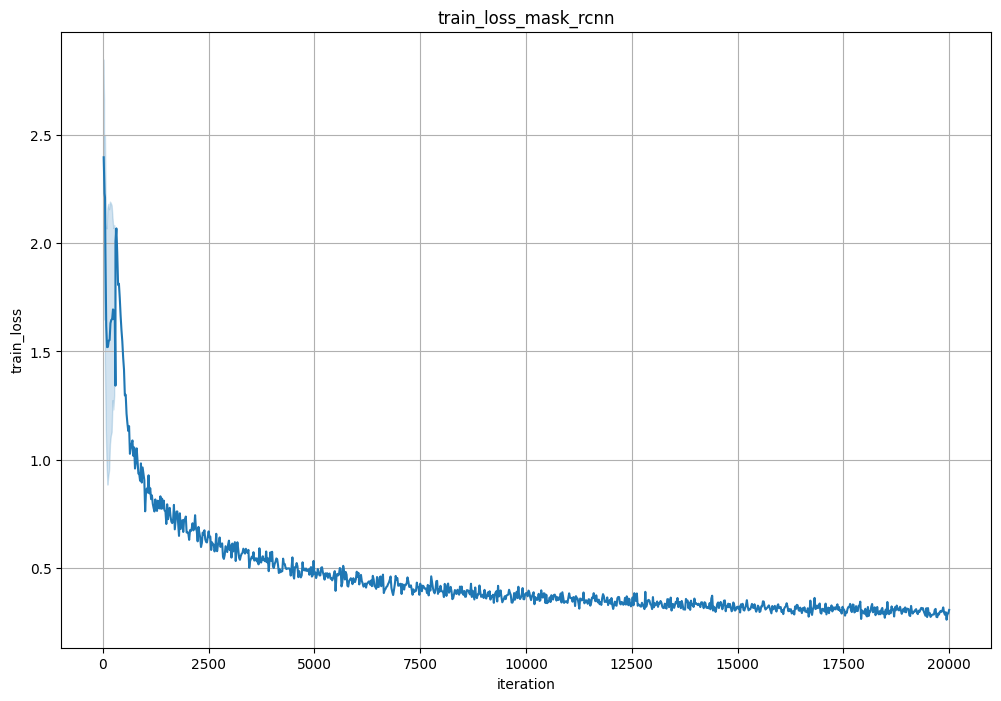

In [25]:
model_name = "mask_rcnn"
plt.figure(figsize=(12,8))
plt.grid()
plt.title('train_loss_{}'.format(model_name))
fig = sns.lineplot(x='iteration', y='train_loss', data=train_loss_df)
fig.figure.savefig(os.path.join(output_path, "train_loss_{}.png".format(model_name)), dpi=300)

In [29]:
try:
    MetadataCatalog.remove('oral_{}_test'.format(version))
    DatasetCatalog.remove('oral_{}_test'.format(version))
except Exception:
    pass

In [30]:
for d in ["test"]:
    DatasetCatalog.register("oral_{}_{}".format(version, d), lambda d=d: get_dicts(d))
    MetadataCatalog.get("oral_{}_{}".format(version, d)).set(thing_classes=meta.get('class',[]))
oral_cancer_metadata_test = MetadataCatalog.get("oral_{}_test".format(version))

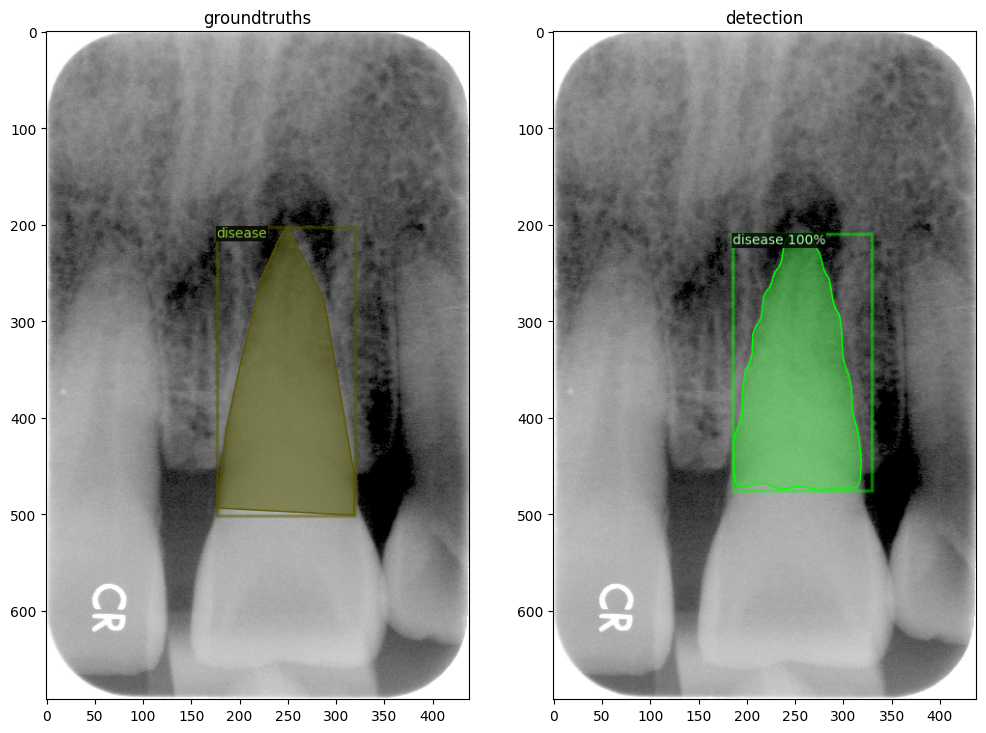

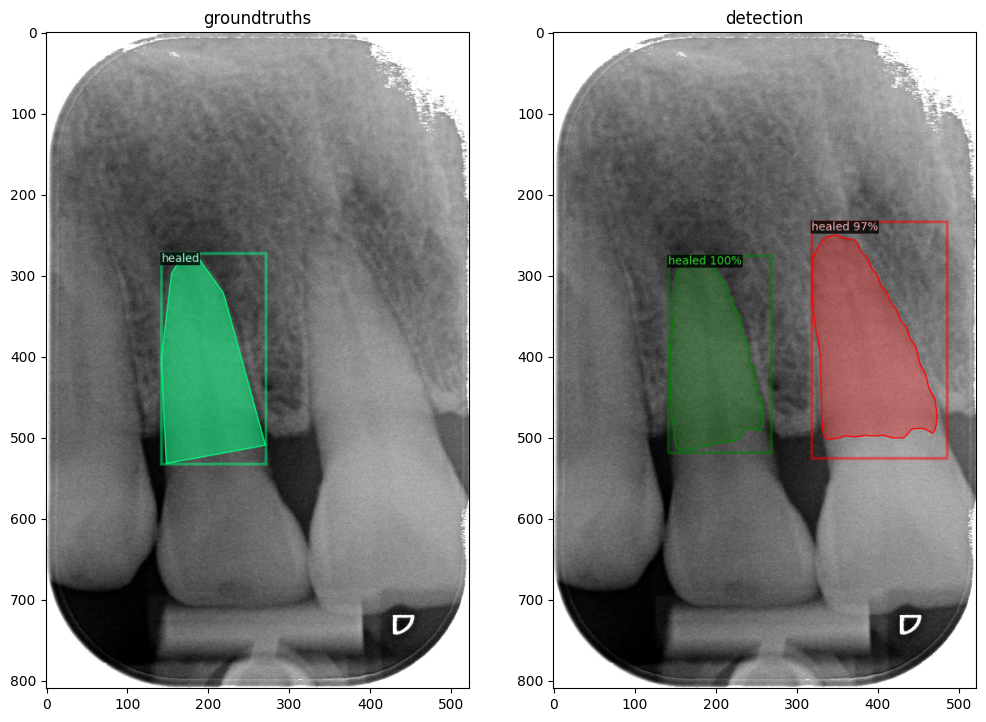

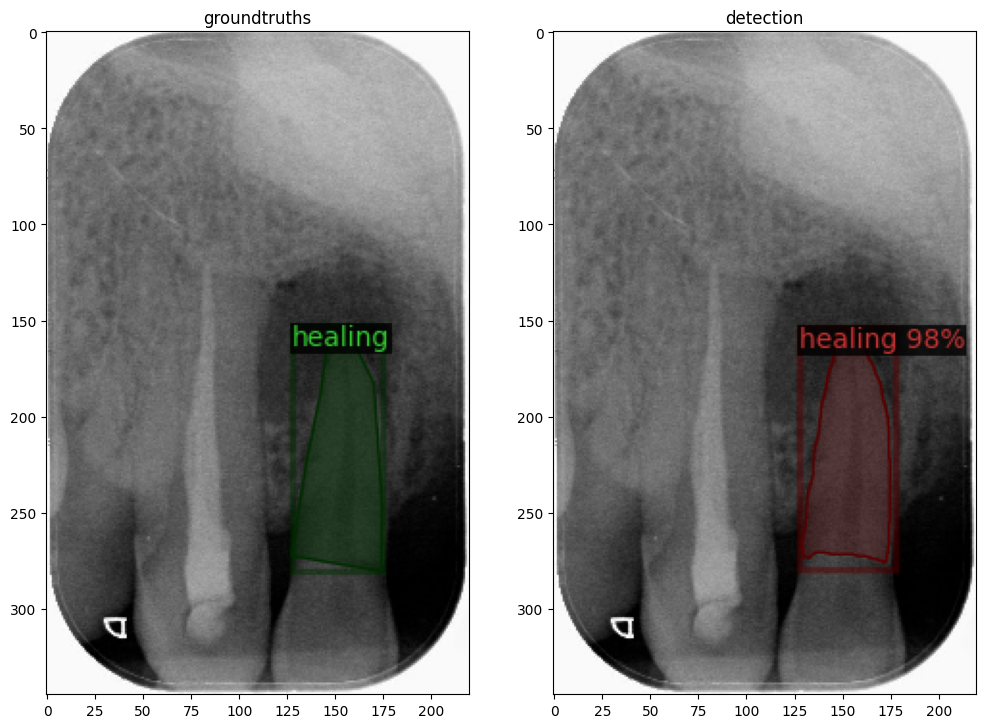

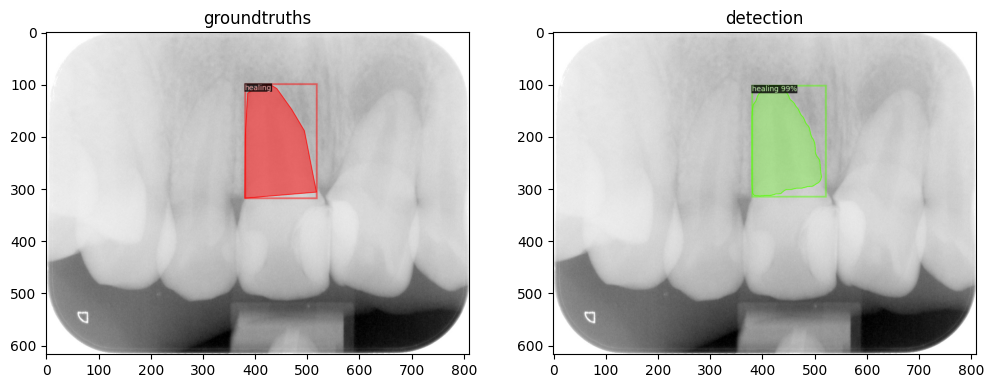

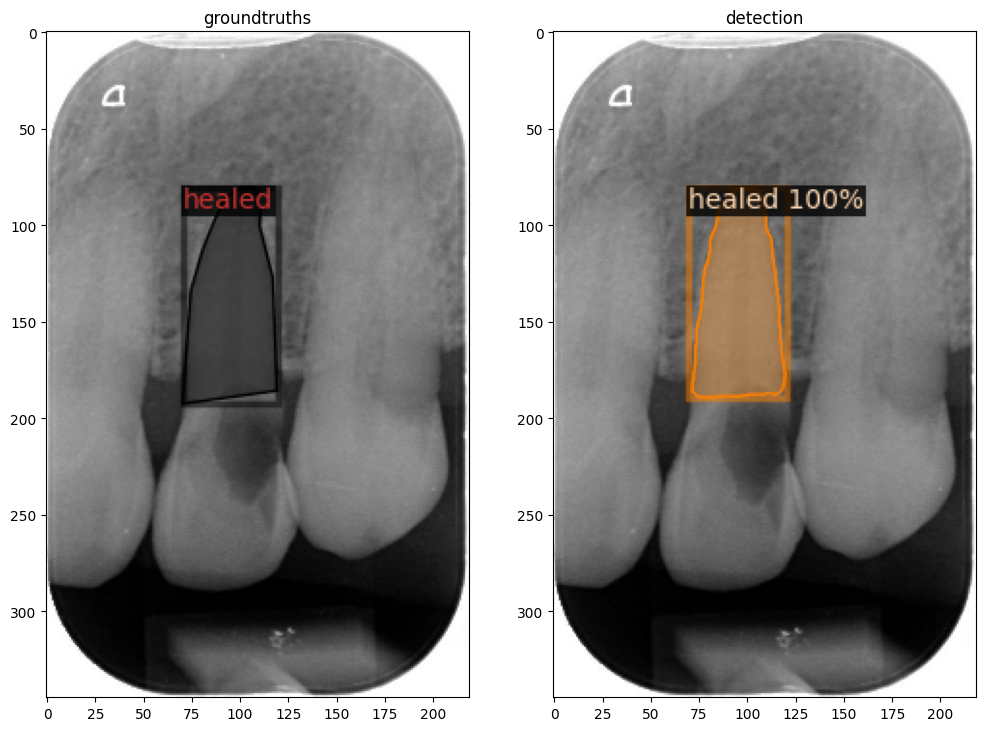

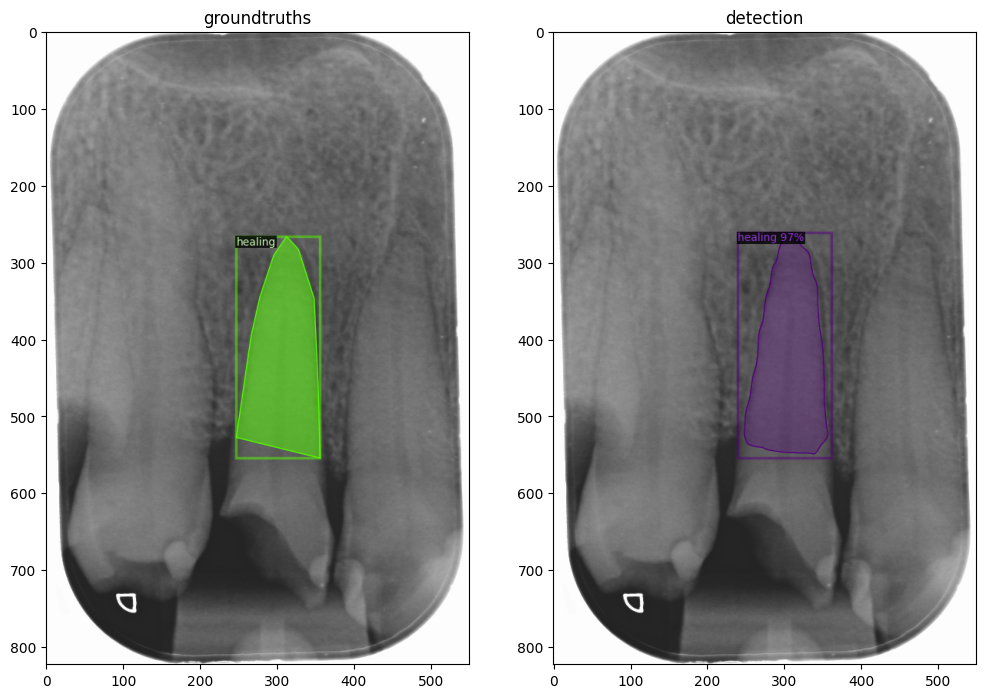

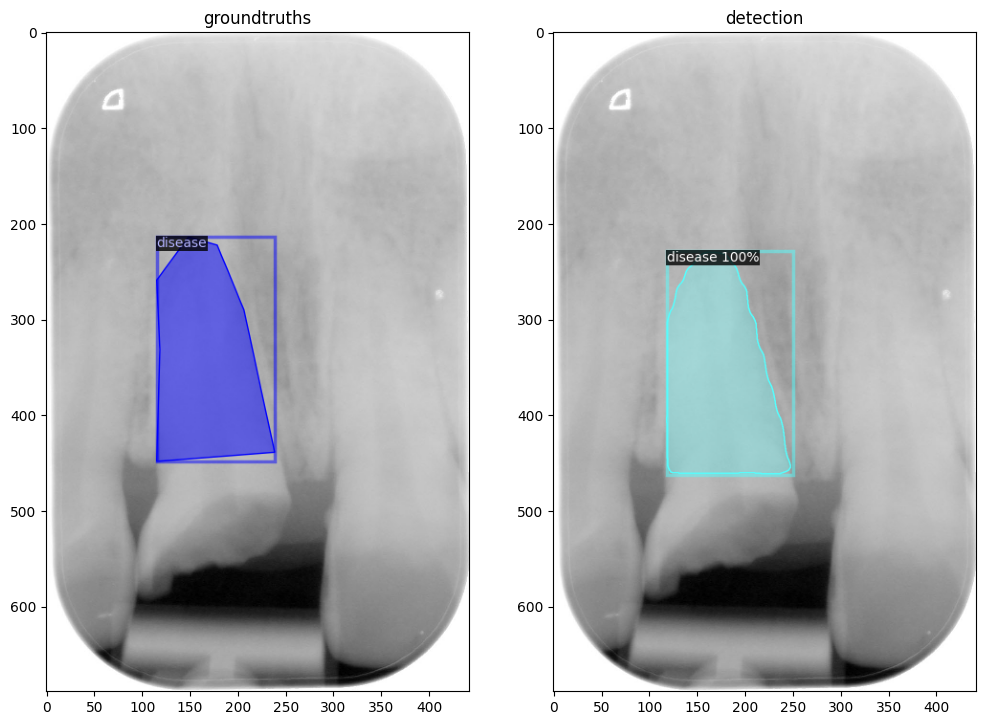

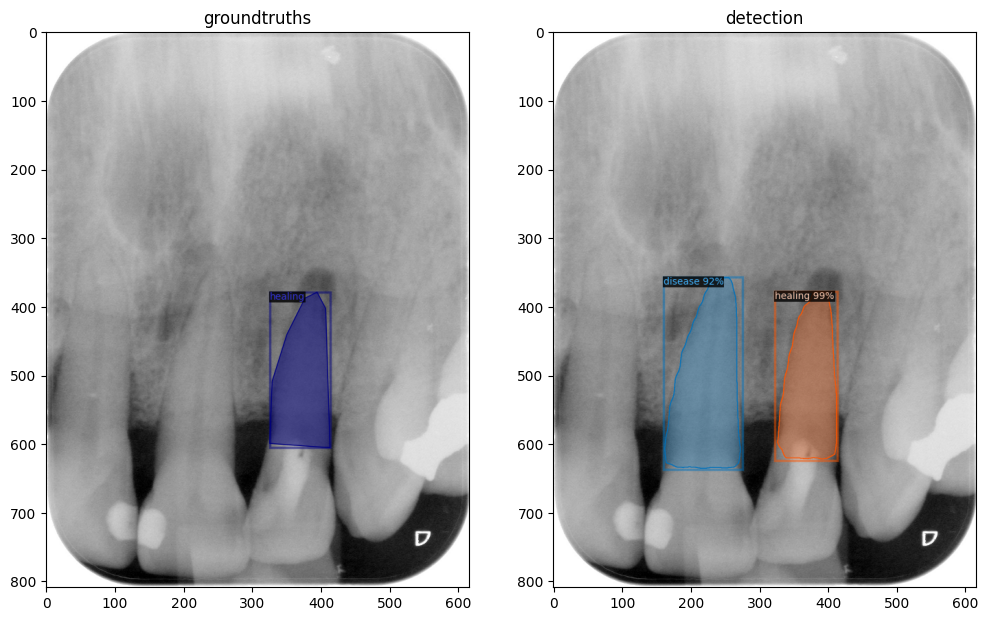

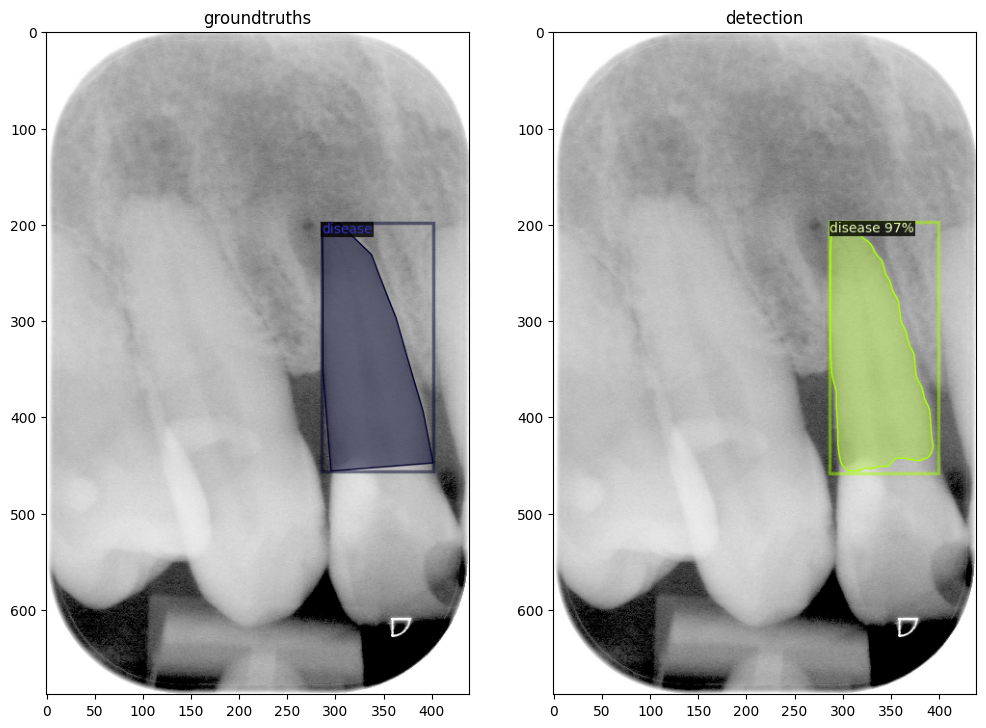

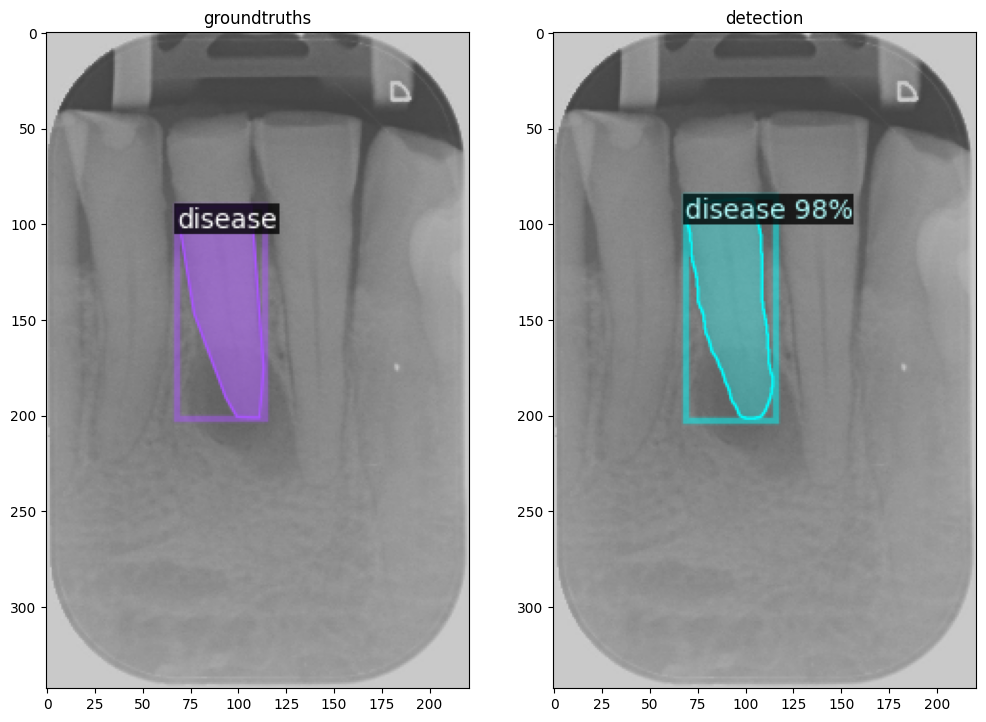

In [31]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_dicts("test")
dataset_dicts = get_dicts("test")
for d in random.sample(dataset_dicts, 10):
    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=oral_cancer_metadata_test, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    pred_out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    visualizer = Visualizer(im[:, :, ::-1], metadata=oral_cancer_metadata, scale=0.5)
    try:
        gt_out = visualizer.draw_dataset_dict(d)
    except Exception:
        gt_out = None

    fig, ax = plt.subplots(1,2, figsize=(12,12))
    if gt_out is not None:
        ax[0].imshow(cv2plt(gt_out.get_image()[:, :, ::-1]))
    else:
        ax[0].imshow(cv2plt(im))
    ax[0].set_title('groundtruths')
    ax[1].imshow(cv2plt(pred_out.get_image()[:, :, ::-1]))
    ax[1].set_title('detection')
    plt.show()

In [32]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("oral_{}_test".format(version), cfg, False, output_dir=output_path)
val_loader = build_detection_test_loader(cfg, "oral_{}_test".format(version))
result = inference_on_dataset(predictor.model, val_loader, evaluator)
print(result)

WARNING [07/25 14:13:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[07/25 14:13:17 d2.evaluation.coco_evaluation]: Trying to convert 'oral_79_test' to COCO format ...
[07/25 14:13:17 d2.data.datasets.coco]: Converting annotations of dataset 'oral_79_test' to COCO format ...)
[07/25 14:13:17 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/25 14:13:17 d2.data.datasets.coco]: Conversion finished, #images: 230, #annotations: 230
[07/25 14:13:17 d2.data.datasets.coco]: Caching COCO format annotations at 'output/fRcnn/oral_79_test_coco_format.json' ...
[07/25 14:13:17 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  disease   | 70           |   healed   | 90           |  healing  

In [33]:
print("{} | model : {}".format(version, model_name))
pd.DataFrame(result)

79 | model : mask_rcnn


bbox       segm
AP          59.962694  59.890533
AP50        79.869049  79.869049
AP75        75.284347  73.936000
APs               NaN        NaN
APm               NaN        NaN
APl         59.962694  59.890533
AP-disease  69.192139  71.158311
AP-healed   54.785820  54.626640
AP-healing  55.910123  53.886647

In [34]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from detectron2.structures.boxes import pairwise_iou, Boxes
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

In [35]:
base_dir = "dataset"
base_output = os.path.join('output', 'fRcnn')

In [36]:
with open(os.path.join(base_dir, 'dataset-meta.json'), 'r') as f:
    meta = json.load(f)
meta

{'class': ['disease', 'healed', 'healing']}

In [38]:
from detectron2.engine import DefaultTrainer, launch

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("oral_{}_train".format(version),)
cfg.DATASETS.TEST = ("oral_{}_validate".format(version),)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.NUM_GPUS = 1

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(meta.get('class'))

os.makedirs(output_path, exist_ok=True)
cfg.OUTPUT_DIR = output_path

# skip blank annotation
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False

cfg.OUTPUT_DIR = base_output
cfg.MODEL.WEIGHTS = os.path.join(base_output, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
predictor = DefaultPredictor(cfg)

In [39]:
detected_path = os.path.join(base_output,'detections')
groundtruth_path = os.path.join(base_output, 'groundtruths')

if not os.path.exists(detected_path):
    os.makedirs(detected_path)
if not os.path.exists(groundtruth_path):
    os.makedirs(groundtruth_path)

In [96]:
ious = 0
n = 0
result = []
err = []
dataset_dicts = get_dicts("test")

for d in tqdm(dataset_dicts):
    im = cv2.imread(d["file_name"])
    
    # detections
    outputs = predictor(im)['instances']
    pred_bboxs = [elm for elm in zip(outputs.pred_classes, outputs.pred_boxes, outputs.scores)]
    label, result_tmp = [], []
    for pred_cls, pred_bbox, score in pred_bboxs:
        pred_cls = pred_cls.tolist()
        x1,y1,x2,y2 = [int(elm) for elm in pred_bbox.tolist()]
        w,h = x2-x1, y2-y1
        score = round(score.tolist(),2)
        try:
            cls_name = meta.get('class')[pred_cls]
        except Exception as e: 
            err.append((e, pred_cls))
            continue
        label.append("{},{},{},{},{},{}".format(cls_name, score,x1, y1, w, h))
        result_tmp.append({
            'image_id':d['image_id'],
            'type':"detections",
            'cls':meta.get('class')[pred_cls],
            'score':score,
            'x':x1,
            'y':y1,
            'w':w,
            'h':h
        })
    result += result_tmp
    if len(label)==0:
#         label.append("{} {} {} {} {} {}".format('normal', 0, 0, 0, 0, 0))
        label.append("")
    file_path = os.path.join(detected_path, "{}.txt".format(d['image_id']))
    with open(file_path, 'w') as f:
        f.write("\n".join(label))
    
    # groundtruths
    label, result_tmp = [], []
    for obj in d['annotations']:
        x1,y1,x2,y2 = [int(elm) for elm in obj['bbox']]
        w,h = x2-x1, y2-y1
        label.append("{},{},{},{},{}".format(meta.get('class')[obj['category_id']],x1, y1, w, h))
        result_tmp.append({
            'image_id':d['image_id'],
            'type':"groundtruths",
            'cls':meta.get('class')[obj['category_id']],
            'x':x1,
            'y':y1,
            'w':w,
            'h':h
        })
    result += result_tmp
    file_path = os.path.join(groundtruth_path, "{}.txt".format(d['image_id']))
    with open(file_path, 'w') as f:
        f.write("\n".join(label))

  0%|          | 0/230 [00:00<?, ?it/s]

In [47]:
err

[]

In [48]:
df_result = pd.DataFrame(result)
df_result

image_id          type      cls  score     x    y    w     h
0        3368    detections   healed   1.00   386  221  128   308
1        3368    detections   healed   0.89   130  197  114   356
2        3368  groundtruths   healed    NaN   383  221  132   292
3        3423    detections   healed   0.99  1200  294  302   610
4        3423  groundtruths   healed    NaN  1205  276  282   583
..        ...           ...      ...    ...   ...  ...  ...   ...
546      2479    detections  healing   0.86   178  706  441  1267
547      2479  groundtruths  disease    NaN   789  831  532  1244
548      2721    detections  disease   1.00   211  383  252   600
549      2721    detections  healing   0.80   511  330  270   644
550      2721  groundtruths  disease    NaN   195  392  265   623

[551 rows x 8 columns]

In [49]:
os.makedirs(base_output, exist_ok=True)
df_result.to_csv(os.path.join(base_output, 'test_result.csv'))

In [65]:
def draw_ret_text_pred(img, data, cls_name, scale=2):
    img = img.copy()
    pred_bboxs = [elm for elm in zip(data.pred_classes, data.pred_boxes, data.scores)]
    for pred_cls, pred_bbox, score in pred_bboxs:
        pred_cls = pred_cls.tolist()
        x1,y1,x2,y2 = [int(elm) for elm in pred_bbox.tolist()]
        score = round(score.tolist(),2)
        txt = "{} | {}".format(cls_name[pred_cls], score) 
        img = cv2.rectangle(img=img, pt1=(int(x1),int(y1)), pt2=(int(x2),int(y2)), color=(0,255,0), thickness=scale*2)
        img = cv2.putText(img, txt, (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, scale, (0,255,0), scale, cv2.LINE_AA)
    return img

def draw_ret_text_gt(img, data, cls_name, scale=2):
    img = img.copy()
    for bbox in data['annotations']:
        x1,y1,x2,y2 = [int(elm) for elm in bbox['bbox']]
        name = cls_name[bbox['category_id']]
        img = cv2.rectangle(img=img, pt1=(x1,y1), pt2=(x2,y2), color=(0,255,255), thickness=scale*2)
    return img

In [51]:
dirs = ["test_image", "test_fig"]
try:
    for d in dirs:
        shutil.rmtree(os.path.join(base_output, d))
except Exception:
    print("dircetory claered")

dircetory claered


In [52]:
# make output dir
os.makedirs(os.path.join(base_output, "test_image"), exist_ok=True)
os.makedirs(os.path.join(base_output, "test_fig"), exist_ok=True)

In [ ]:
ious = 0
n = 0

from detectron2.structures.boxes import pairwise_iou, Boxes
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dicts("test")

class_name = meta.get('class')
print(f"class {class_name}")
# for d in random.sample(dataset_dicts, 20):
for d in tqdm(dataset_dicts):
    im = cv2.imread(d["file_name"])
    H,W = im.shape[:2]
    scale = (H+W)//800

    outputs = predictor(im)

    pred_img = draw_ret_text_pred(im, outputs["instances"].to("cpu"), class_name, scale=scale)
    gt_img = draw_ret_text_gt(im, d, class_name, scale=scale)
    fig, ax = plt.subplots(ncols=3, figsize=(12,12))
    
    ax[0].imshow(cv2plt(im))
    ax[0].title.set_text("original")
    ax[1].imshow(cv2plt(gt_img))
    ax[1].title.set_text("groundtruths")
    ax[2].imshow(cv2plt(pred_img))
    ax[2].title.set_text("detections")

    
    pred_bbox = outputs['instances'].pred_boxes
    try:
        label_box = torch.from_numpy(np.array(d['annotations'][0]['bbox'],dtype=np.float32))
    except Exception:
        label_box = torch.from_numpy(np.zeros(4))
    label_bbox = Boxes(label_box.to('cuda').reshape(-1,4))
    iou = pairwise_iou(pred_bbox, label_bbox)
    
    outputs = outputs['instances']
    pred_bboxs = [elm for elm in zip(outputs.pred_classes, outputs.pred_boxes, outputs.scores)]
    for i in [float(i) for i in iou]:
        ious += i
        n += 1
        
    f_name, f_ext = d["file_name"].split('/')[-1].split('.')
    for cls, frame in [("original", im), ("detections", pred_img), ("groundtruths", gt_img)]:
        f_img_path = os.path.join(base_output, "test_image", "{}_{}.{}".format(f_name, cls, f_ext))
        cv2.imwrite(f_img_path, frame)
    
    fig_title = fig.suptitle(f_name + " : IOU => " + " | ".join(["{:.2f}".format(float(i)) for i in iou]))
    fig.savefig(os.path.join(base_output, "test_fig","fig_{}.jpg".format(f_name)), dpi=200)
#     plt.show()

In [68]:
import shutil
from distutils.dir_util import copy_tree
from subprocess import Popen, PIPE

In [69]:
# clone project
os.system("git clone https://github.com/SothanaV/Object-Detection-Metrics.git")

Cloning into 'Object-Detection-Metrics'...


0

In [98]:
dirs = ["detections", "groundtruths"]
# clear example 
for d in dirs: shutil.rmtree(os.path.join("Object-Detection-Metrics", d))

# make directory for data
for d in dirs: os.makedirs(os.path.join(os.path.join("Object-Detection-Metrics", d)), )

# copy detection and groundtruths
for d in dirs: copy_tree(os.path.join(base_output, d), os.path.join("Object-Detection-Metrics", d))

In [101]:
os.chdir('Object-Detection-Metrics')
shutil.rmtree('results')
p1 = Popen(["python3", "pascalvoc.py"], stdout=PIPE, stdin=PIPE)
print(p1.communicate(b"Y")[0].decode())
os.chdir('..')



####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, Wesley L. and Dias, Thadeu L. B. and 

In [102]:
copy_tree(os.path.join("Object-Detection-Metrics", "results"), os.path.join(base_output))

['output/fRcnn/results.txt', 'output/fRcnn/results.json']

In [103]:
with open(os.path.join('Object-Detection-Metrics', 'results', 'results.json'), 'r') as f:
    results = json.load(f)

In [104]:
extract_result = {}
for cls in results:
    if type(results[cls]) == dict:
        extract_result[cls] = {
            "Precision": (results[cls]['total_TP'])/(results[cls]['total_TP'] + results[cls]['total_FP']) ,
            "Recall": (results[cls]['total_TP'])/(results[cls]['total_TP'] + results[cls]['total_FN']),
#             "AP":results['mAP'],
            "total_TP":results[cls]['total_TP'],
            "total_FP":results[cls]['total_FP'],
            "total_FN":results[cls]['total_FN'],
        }
        extract_result[cls]['F1'] = 2*( (extract_result[cls]['Precision']*extract_result[cls]['Recall'])/(extract_result[cls]['Precision']+extract_result[cls]['Recall']) )
extract_result

{'disease': {'Precision': 0.7816091954022989,
  'Recall': 0.9714285714285714,
  'total_TP': 68,
  'total_FP': 19,
  'total_FN': 2,
  'F1': 0.8662420382165605},
 'healed': {'Precision': 0.5448717948717948,
  'Recall': 0.9444444444444444,
  'total_TP': 85,
  'total_FP': 71,
  'total_FN': 5,
  'F1': 0.6910569105691056},
 'healing': {'Precision': 0.6794871794871795,
  'Recall': 0.7571428571428571,
  'total_TP': 53,
  'total_FP': 25,
  'total_FN': 17,
  'F1': 0.7162162162162163}}

In [105]:
from sklearn.metrics import roc_curve, auc as AUC

In [106]:
for cls in extract_result:
    auc = AUC(results[cls]['recall'], results[cls]['precision'])
    extract_result[cls]['auc'] = auc
    print("{} \t| AUC : {}".format(cls, auc))

disease 	| AUC : 0.9148328755480641
healed 	| AUC : 0.713990334297282
healing 	| AUC : 0.680333555190592


In [107]:
df_result = pd.DataFrame(extract_result)
df_result.to_excel(os.path.join(base_output, "result.xlsx"))
df_result

disease     healed    healing
Precision   0.781609   0.544872   0.679487
Recall      0.971429   0.944444   0.757143
total_TP   68.000000  85.000000  53.000000
total_FP   19.000000  71.000000  25.000000
total_FN    2.000000   5.000000  17.000000
F1          0.866242   0.691057   0.716216
auc         0.914833   0.713990   0.680334

In [108]:
# pip install openpyxl

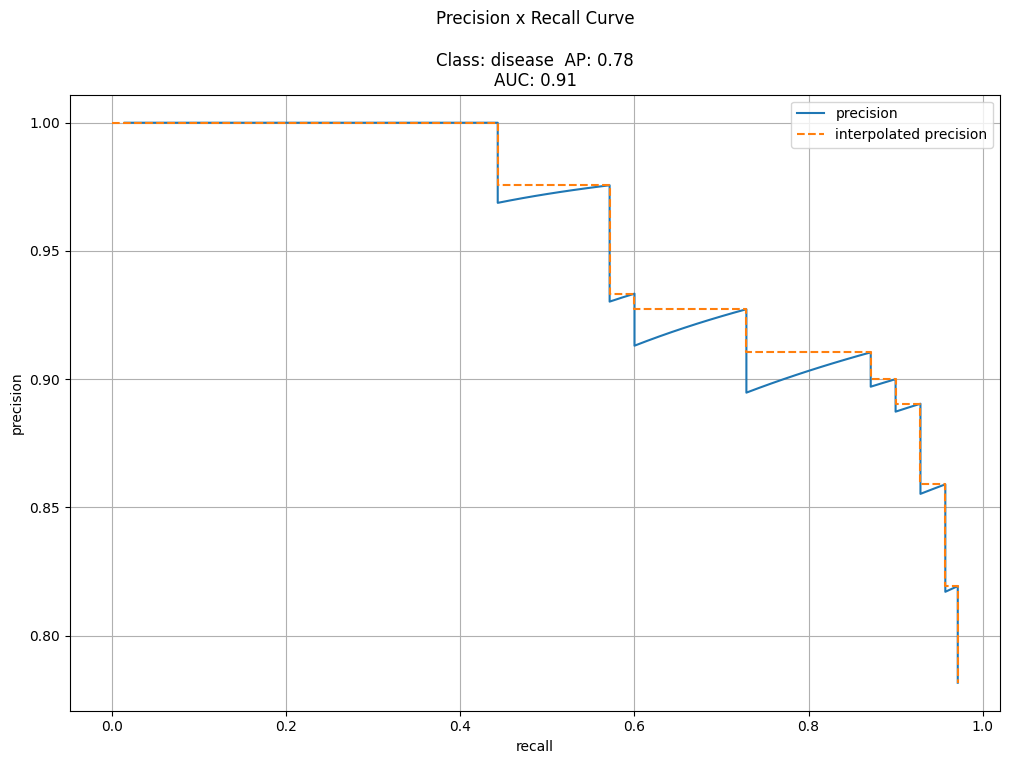

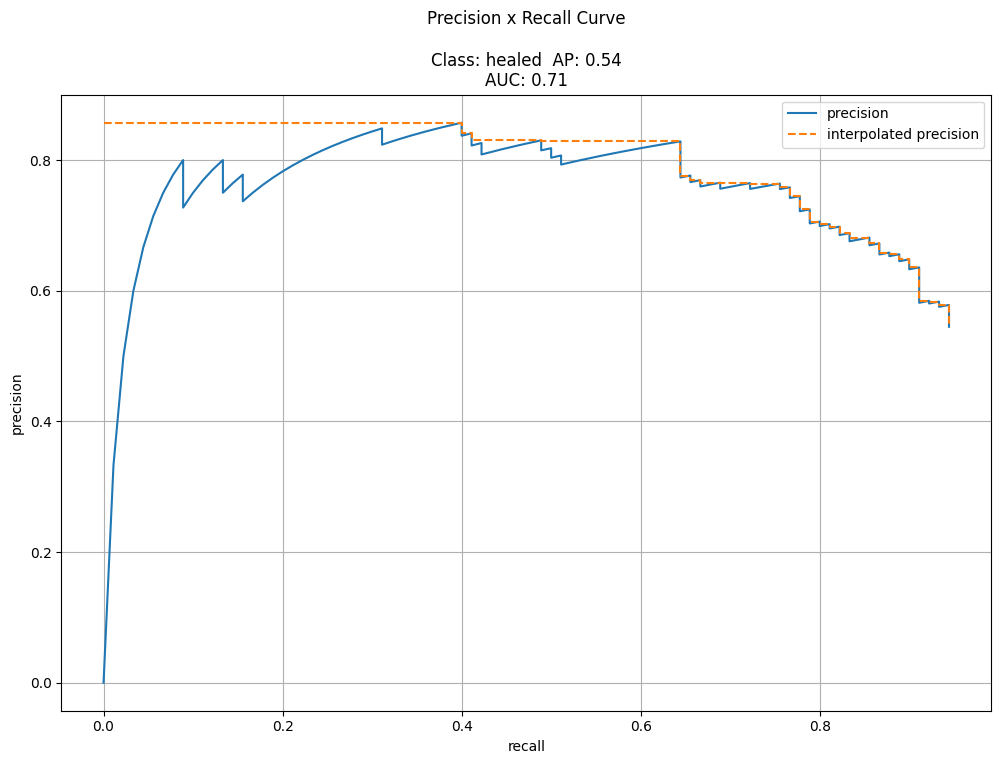

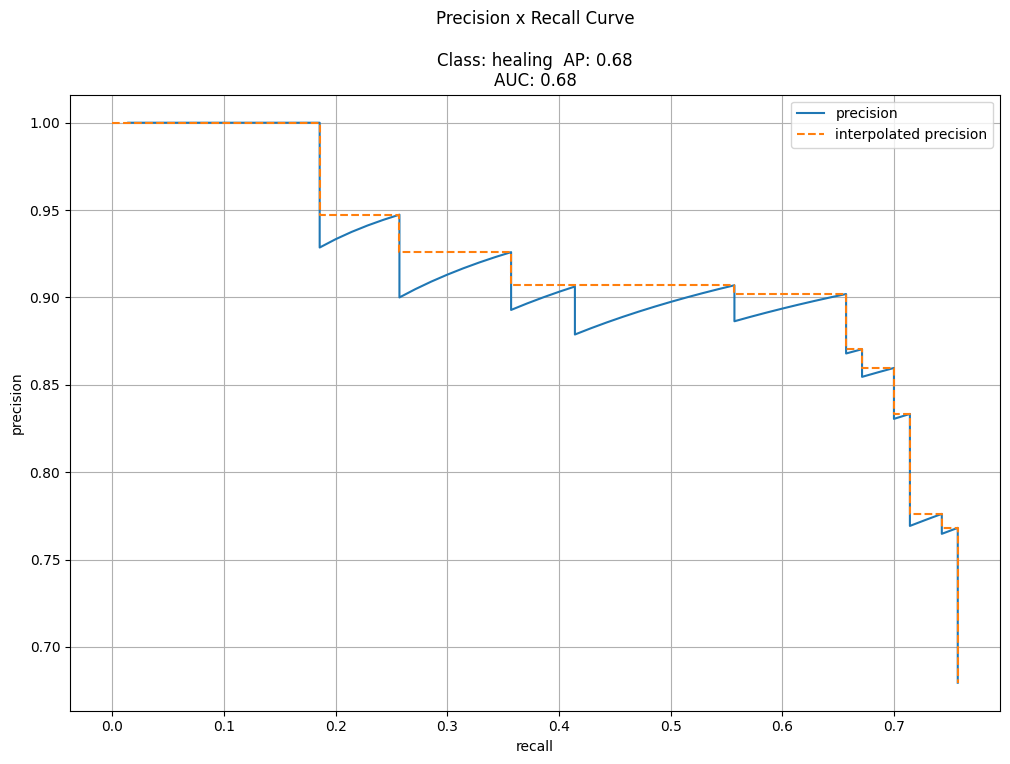

In [110]:
for cls in extract_result:
    plt.figure(figsize=(12,8))
    plt.grid()
    plt.title("Precision x Recall Curve\n \nClass: {}  AP: {:.2f}\nAUC: {:.2f}".format(cls,extract_result[cls]['Precision'], extract_result[cls]['auc']))
    plt.plot(results[cls]['recall'], results[cls]['precision'], label='precision')
    plt.plot(results[cls]['interpolated_recall'], results[cls]['interpolated_precision'], "--", label='interpolated precision')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    plt.savefig(os.path.join("output","fRcnn","Precision_Recall_Curve_{}.png".format(cls)))
    plt.show()